# Pre-Equilibrium Maximazation of Yield #

In [1]:
# make sure jupyter path is correct for loading local moudules
import sys
# path to steric_simulator module relative to notebook
sys.path.append("../../")
import copy

In [2]:
from steric_free_simulator import ReactionNetwork, VectorizedRxnNet, VecSim, Optimizer, EquilibriumSolver

EnergyExplorer Module is not available. Check Rosetta installation. <ipykernel.iostream.OutStream object at 0x7fbdc98ab9e8>


We'll start with the AP2 complex that we've worked with before. Pairwise $\Delta Gs$ were derived from the PDB structures via Rossetta

In [3]:
base_input = '../input_files/trimer.pwr'
rn = ReactionNetwork(base_input, one_step=True)
print(rn.rxn_coupling)
rn.resolve_tree()
print(rn.rxn_coupling)

['default_assoc', 1.0]
['A']
100.0
['B']
100.0
['C']
100.0
Parsing rule...
['A(a)+B(a)<->A(a!1).B(a!1)', 'G=-20']
['A', 'B', '']
['A(a)+B(a)', 'A(a!1).B(a!1)']
GGGGGGGGGgg
Parsing rule...
['A(b)+C(b)<->A(b!1).C(b!1)', 'G=-20']
['A', 'C', '']
['A(b)+C(b)', 'A(b!1).C(b!1)']
GGGGGGGGGgg
Parsing rule...
['B(b)+C(a)<->B(b!1).C(a!1)', 'G=-20']
['B', 'C', '']
['B(b)+C(a)', 'B(b!1).C(a!1)']
GGGGGGGGGgg
False
Node-1 :  (0, {'struct': <networkx.classes.graph.Graph object at 0x7fbd32fd5c50>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1})
Node-2 :  (0, {'struct': <networkx.classes.graph.Graph object at 0x7fbd32fd5c50>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1})
-----
{'A'}
{'A'}
set()
Steric hindrance detected
Node-1 :  (0, {'struct': <networkx.classes.graph.Graph object at 0x7fbd32fd5c50>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1})
Node-2 :  (1, {'struct': <networkx.classes.graph.Graph object at 0x7fbd34188a58>, 'copies': tensor([100.], dtyp

In [4]:
def decompose_monomers(n1,monomer_set):
        if len(rn.network.in_edges(n1)) == 0:
            return(True,monomer_set)
        else:
            for incoming_edge in rn.network.in_edges(n1):
                flag,monomer_set = decompose_monomers(incoming_edge[0],monomer_set)
                if flag:
                    monomer_set.append(incoming_edge[0])
            return(False,monomer_set)

In [5]:
uid_dict = {}
sys.path.append("../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    print(n)
    #print(rn.network.nodes()[n])
    
    flag,monomer_set = decompose_monomers(n,[])
    
    print("Node - ", gtostr(rn.network.nodes[n]['struct']), "--", set(monomer_set))
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_dict[(n,k)] = uid

print(uid_dict)
# print(rn.mon_rxns)
# print(gtostr(rn.network.nodes[3]['struct']),rn.network.nodes[3]['struct'].number_of_edges())

# print(rn.network.edges(data=True))

# print(rn.uid_map)

print(rn.rxn_cid)

0
Node -  A -- set()
1
Node -  B -- set()
2
Node -  C -- set()
3
Node -  AB -- {0, 1}
4
Node -  AC -- {0, 2}
5
Node -  BC -- {1, 2}
6
Node -  ABC -- {0, 1, 2}
{(0, 3): 0, (0, 4): 1, (0, 6): 5, (1, 3): 0, (1, 5): 2, (1, 6): 3, (2, 4): 1, (2, 5): 2, (2, 6): 4, (3, 6): 4, (4, 6): 3, (5, 6): 5}
{}


In [6]:
#Changing Initial Conditions
import networkx as nx
#Changin k_on
new_kon = [1.0,1.0,1.0,1.0,1.0,1.0]*np.array([1e0])  #Poor yield Simruntime = 1sec
# new_kon = [ 0.1411,  0.1917,  0.1205, 42.6304, 42.7995, 42.6389]*np.array([1e0])
# new_kon = [0.4052, 0.4145, 0.4049, 5.0401, 5.9947, 5.9940]

update_kon_dict = {}
for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))
    update_kon_dict[edge] = new_kon[uid_dict[edge]]

nx.set_edge_attributes(rn.network,update_kon_dict,'k_on')

# for edge in rn.network.edges:
#     print(rn.network.get_edge_data(edge[0],edge[1]))
# vec_rn = VectorizedRxnNet(rn, dev='cpu',rxn_coupling=True,rx_cid={3:[1],4:[0],5:[2]})
vec_rn = VectorizedRxnNet(rn, dev='cpu',assoc_is_param=False,dissoc_is_param=True)
print(vec_rn.kon)


{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 5}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 2}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 3}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 2}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 4}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 4}
{'k_on': 1

## The Equilibrium Solution ##
First we will find the equilibrium solution for this system.

In [7]:
vec_rn.update_reaction_net(rn,1)
poly_system = EquilibriumSolver(rn)
solution = poly_system.solve()
if solution == None:
    print("No Equilibrium solution")
else:
    print(solution)
    print("Equilibrium expected yield: ", 100 * solution[-1] / min(vec_rn.initial_copies[:vec_rn.num_monomers]), '%')
print(vec_rn.kon)

No aceeptable solution found
No Equilibrium solution
tensor([1., 1., 1., 1., 1., 1.], dtype=torch.float64, grad_fn=<CopySlices>)


In [8]:
print(vec_rn.rxn_coupling)
print(rn.rxn_coupling)

False
False


In [9]:
uid_dict = {}
sys.path.append("../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    #print(n)
    #print(rn.network.nodes()[n])
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_val = {'reactants':reactants,'kon':v['k_on'],'score':v['rxn_score'],'koff':v['k_off'],'uid':uid}
        if uid not in uid_dict.keys():
            uid_dict[uid] = uid_val
    print(gtostr(rn.network.nodes[n]['struct']))
    #for r_set in rn.get_reactant_sets(n):
    #    print(tuple(r_set))
    #print(rn.network[n]['struct'])
ind_sort = np.argsort(vec_rn.kon.detach().numpy())
for i in ind_sort:
    print(vec_rn.kon[i])
    print(uid_dict[i])

A
B
C
AB
AC
BC
ABC
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'A'}, {'B'}), 'kon': 1.0, 'score': tensor([-20.], dtype=torch.float64), 'koff': 0.002061153622438557, 'uid': 0}
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'A'}, {'C'}), 'kon': 1.0, 'score': tensor([-20.], dtype=torch.float64), 'koff': 0.002061153622438557, 'uid': 1}
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'B'}, {'C'}), 'kon': 1.0, 'score': tensor([-20.], dtype=torch.float64), 'koff': 0.002061153622438557, 'uid': 2}
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'B'}, {'A', 'C'}), 'kon': 1.0, 'score': tensor([-40.], dtype=torch.float64), 'koff': 4.248354255291587e-12, 'uid': 3}
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'C'}, {'A', 'B'}), 'kon': 1.0, 'score': tensor([-40.], dtype=torch.float64), 'koff': 4.248354255291587e-12, 'uid': 4}
tensor(1., dtype=torch.float64, grad_fn

In [10]:
uid_dict = {}
sys.path.append("../")
import numpy as np
from reaction_network import gtostr
from torch import DoubleTensor as Tensor
import torch

node_map = {}
for node in rn.network.nodes():
    node_map[gtostr(rn.network.nodes[node]['struct'])] = node

print(node_map)

def get_max_edge(n):
    """
    Calculates the max rate (k_on) for a given node
    To find out the maximum flow path to the final complex starting from the current node.
    
    Can also calculate the total rate of consumption of a node by summing up all rates. 
    Can tell which component is used quickly.
    """
    try:
        edges = rn.network.out_edges(n)
        #Loop over all edges
        #Get attributes
        if len(edges)==0:
            return(False)
        kon_max = -1
        next_node = -1
        
        kon_sum = 0
        for edge in edges:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']
            #Get updated kon
            temp_kon = vec_rn.kon[uid]
            kon_sum+=temp_kon
            
            if temp_kon > kon_max:
                kon_max = temp_kon
                next_node=edge[1]
        return(kon_max,next_node,kon_sum)
    except Exception as err:
        raise(err)
def get_node_flux(n):
    total_flux_outedges = 0
    total_flux_inedges = 0
    #Go over all the out edges
    edges_out = rn.network.out_edges(n)
    if len(edges_out)>0:

        for edge in edges_out:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']

            #Get updated kon
            temp_kon = vec_rn.kon[uid]

            #Calculate k_off also
            std_c = Tensor([1.])
            l_kon = torch.log(temp_kon)
            l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
            koff = torch.exp(l_koff)

            #Getting conc. of reactants and products
            #Get product
            prod = gtostr(rn.network.nodes[edge[1]]['struct']) 
            #Get other reactant
            react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))

            #Net flux from this edge = Generation - consumption
            edge_flux = koff*solution[edge[1]] - temp_kon*(solution[edge[0]])*(solution[node_map[react]])
            #edge_flux = koff*vec_rn.copies_vec[edge[1]] 

            print("Reaction: ", gtostr(rn.network.nodes[edge[0]]['struct']), "+",react," -> ",prod)
            print("Net flux: ",edge_flux)
            print("kon : ",temp_kon)
            print("koff: ",koff)
            print("Free Energy: ",vec_rn.rxn_score_vec[uid])
            print("Reaction data OUTWARD: ")
            print(data)

            total_flux_outedges+=edge_flux
    
    #Now go over all the in edges
    edges_in = rn.network.in_edges(n)
    react_list = []
    if len(edges_in) > 0:
        for edge in edges_in:
            if edge[0] in react_list:
                continue
            data = rn.network.get_edge_data(edge[0],edge[1])
            uid = data['uid']


            #Get generation rates; which would be kon
            temp_kon = vec_rn.kon[uid]

            #Get consumption rates; which is k_off
            std_c = Tensor([1.])
            l_kon = torch.log(temp_kon)
            l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
            koff = torch.exp(l_koff)

            #Get conc. of reactants and products
            prod = gtostr(rn.network.nodes[edge[1]]['struct'])
            #Get other reactant
            react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))
            react_list.append(node_map[react])
            #Net flux from this edge = Generation - consumption
            edge_flux_in = temp_kon*(solution[edge[0]])*(solution[node_map[react]])- koff*solution[edge[1]]
            #edge_flux_in = koff*vec_rn.copies_vec[edge[1]]
            


            print("Reaction: ", prod ," -> ",gtostr(rn.network.nodes[edge[0]]['struct']), "+",react)
            print("Net flux: ",edge_flux_in)
            print("kon : ",temp_kon)
            print("koff: ",koff)
            print("Raction data INWARD: ")
            print(data)

            total_flux_inedges+=edge_flux_in
    net_node_flux = total_flux_outedges + total_flux_inedges
    
    return(net_node_flux)
pathway = []
kon_sumarray = []
total_con_rate = {}
net_flux = {}

if solution != None:
    for n in rn.network.nodes():

        n_str = gtostr(rn.network.nodes[n]['struct']) 

        paths = [n_str]
        kon_sum = 0
        temp_node = n
        max_edge = True
        consumption_rate = 0
        if n < len(rn.network.nodes()):#num_monomers:
    #         print("Current node: ")
    #         print(n_str)
            while max_edge:
                max_edge = get_max_edge(temp_node)
                if max_edge:
                    total_con_rate[gtostr(rn.network.nodes[temp_node]['struct'])] = max_edge[2]
                    temp_node = max_edge[1]
                    kon_sum += max_edge[0].item()


    #                 print("Next node: ")
    #                 print(temp_node)

                    paths.append(gtostr(rn.network.nodes[temp_node]['struct']))
                else:
                    break
            pathway.append(paths)
            kon_sumarray.append(kon_sum)
            paths=[]

        print("-------------------------------------------------------------------------------")
        print("-------------------------------------------------------------------------------")
        print("|                                                                             |")
        node_flux = get_node_flux(n)
        net_flux[gtostr(rn.network.nodes[n]['struct'])] = node_flux
        print("|                                                                             |")
        print("-------------------------------------------------------------------------------")
        print("-------------------------------------------------------------------------------")

    print(pathway)
    print(kon_sumarray)
    #print(total_con_rate)

{'A': 0, 'B': 1, 'C': 2, 'AB': 3, 'AC': 4, 'BC': 5, 'ABC': 6}


In [11]:
if solution != None:
    for k,v in sorted(total_con_rate.items(),key=lambda x : x[1]):
        print(k," : ", v.item())

In [12]:
if solution !=None:
    for k,v in sorted(net_flux.items(),key=lambda x : x[1]):
        print(k," : ", v)



## Using the optimizer with a 1 second simulation runtime ##

In [13]:
vec_rn.reset(reset_params=True)
optim = Optimizer(reaction_network=vec_rn,
                  sim_runtime=1.0,
                  optim_iterations=5000,
                  learning_rate=new_kon[0]/1e15,
                  device='cpu',method="RMSprop")
optim.rn.update_reaction_net(rn)
optim.optimize()

Using CPU
Reaction Parameters before optimization: 
[Parameter containing:
tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.2484e-12, 4.2484e-12, 4.2484e-12],
       dtype=torch.float64, requires_grad=True)]
Using CPU
Next time:  tensor(10.0163, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 0 was 66.9%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.2584e-12, 4.2384e-12, 4.2584e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(10.0221, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1 was 66.9%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7247, 2.7119, 2.7247], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612

Next time:  tensor(10.1079, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 19 was 67.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7501, 2.7473, 2.7666], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.2996e-12, 4.2956e-12, 4.3255e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(10.1114, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 20 was 67.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7513, 2.7487, 2.7681], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3014e-12, 4.2978e-12, 4.3278e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(10.1148, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation

Next time:  tensor(6.3695, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 38 was 67.8%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7764, 2.7626, 2.7915], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3376e-12, 4.3161e-12, 4.3676e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.9045, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 39 was 67.9%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7760, 2.7620, 2.7957], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3373e-12, 4.3156e-12, 4.3725e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.5904, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
y

Next time:  tensor(5.2653, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 57 was 67.9%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7695, 2.7679, 2.8029], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3276e-12, 4.3253e-12, 4.3788e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.2565, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 58 was 67.9%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7695, 2.7679, 2.8030], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3276e-12, 4.3253e-12, 4.3790e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.2477, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
y

Next time:  tensor(5.1047, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 76 was 68.0%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7695, 2.7679, 2.8051], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3277e-12, 4.3253e-12, 4.3821e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0967, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 77 was 68.0%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7695, 2.7680, 2.8052], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3278e-12, 4.3253e-12, 4.3823e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0886, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
y

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7700, 2.7680, 2.8074], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3284e-12, 4.3254e-12, 4.3856e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9495, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 96 was 68.0%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7700, 2.7680, 2.8075], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3285e-12, 4.3254e-12, 4.3857e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9420, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 97 was 68.0%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7700, 2.7680, 2.8076], dtype=torch.float64,
       grad_fn=<SliceBackward>)
curre

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7708, 2.7681, 2.8098], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3297e-12, 4.3255e-12, 4.3892e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8131, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 115 was 68.0%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7709, 2.7681, 2.8099], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3298e-12, 4.3256e-12, 4.3894e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8062, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 116 was 68.0%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7709, 2.7681, 2.8101], dtype=torch.float64,
       grad_fn=<SliceBackward>)
cur

Next time:  tensor(4.6862, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 134 was 68.0%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7721, 2.7683, 2.8125], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3318e-12, 4.3258e-12, 4.3933e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6797, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 135 was 68.0%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7722, 2.7683, 2.8126], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3320e-12, 4.3258e-12, 4.3935e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6733, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7682, 2.7740, 2.8093], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3257e-12, 4.3346e-12, 4.3885e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9354, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 154 was 68.0%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7682, 2.7740, 2.8094], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3257e-12, 4.3346e-12, 4.3886e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9300, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 155 was 68.0%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7682, 2.7740, 2.8095], dtype=torch.float64,
       grad_fn=<SliceBackward>)
cur

Next time:  tensor(4.8339, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 173 was 68.0%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7688, 2.7741, 2.8112], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3266e-12, 4.3347e-12, 4.3912e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8286, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 174 was 68.0%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7688, 2.7741, 2.8113], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3266e-12, 4.3347e-12, 4.3914e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8234, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7696, 2.7742, 2.8130], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3278e-12, 4.3349e-12, 4.3941e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7307, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 193 was 68.0%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7696, 2.7742, 2.8131], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3279e-12, 4.3349e-12, 4.3942e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7256, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 194 was 68.0%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7697, 2.7742, 2.8132], dtype=torch.float64,
       grad_fn=<SliceBackward>)
cur

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7707, 2.7743, 2.8150], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3295e-12, 4.3351e-12, 4.3971e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6360, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 212 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7707, 2.7743, 2.8152], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3297e-12, 4.3351e-12, 4.3973e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6311, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 213 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7708, 2.7744, 2.8153], dtype=torch.float64,
       grad_fn=<SliceBackward>)
cur

Next time:  tensor(4.5445, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 231 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7722, 2.7745, 2.8173], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3319e-12, 4.3354e-12, 4.4006e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5398, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 232 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7723, 2.7745, 2.8174], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3320e-12, 4.3354e-12, 4.4007e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5351, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.

Next time:  tensor(4.9765, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 251 was 68.0%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7794, 2.7731, 2.8131], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3429e-12, 4.3332e-12, 4.3941e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9718, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 252 was 68.0%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7794, 2.7731, 2.8132], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3429e-12, 4.3332e-12, 4.3942e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9671, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7795, 2.7732, 2.8144], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3429e-12, 4.3333e-12, 4.3961e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8816, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 271 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7795, 2.7732, 2.8145], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3429e-12, 4.3333e-12, 4.3962e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8769, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 272 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7795, 2.7732, 2.8145], dtype=torch.float64,
       grad_fn=<SliceBackward>)
cur

Next time:  tensor(4.7900, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 290 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7795, 2.7733, 2.8159], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3430e-12, 4.3335e-12, 4.3984e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7852, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 291 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7795, 2.7733, 2.8160], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3430e-12, 4.3335e-12, 4.3985e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7803, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.

Next time:  tensor(4.6972, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 309 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7796, 2.7735, 2.8174], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3432e-12, 4.3337e-12, 4.4007e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6922, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 310 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7796, 2.7735, 2.8175], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3432e-12, 4.3338e-12, 4.4008e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6873, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7787, 2.7796, 2.8139], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3418e-12, 4.3432e-12, 4.3954e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0898, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 329 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7787, 2.7796, 2.8140], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3418e-12, 4.3432e-12, 4.3955e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0846, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 330 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7787, 2.7796, 2.8141], dtype=torch.float64,
       grad_fn=<SliceBackward>)
cur

Next time:  tensor(4.9891, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 348 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7787, 2.7796, 2.8154], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3418e-12, 4.3432e-12, 4.3975e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9838, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 349 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7787, 2.7796, 2.8154], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3418e-12, 4.3432e-12, 4.3976e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9785, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7788, 2.7797, 2.8168], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3419e-12, 4.3432e-12, 4.3997e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8819, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 368 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7788, 2.7797, 2.8169], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3419e-12, 4.3432e-12, 4.3998e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8766, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 369 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7788, 2.7797, 2.8170], dtype=torch.float64,
       grad_fn=<SliceBackward>)
cur

Next time:  tensor(4.7793, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 387 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7789, 2.7797, 2.8184], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3420e-12, 4.3433e-12, 4.4022e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7738, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 388 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7789, 2.7797, 2.8185], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3420e-12, 4.3433e-12, 4.4023e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7684, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7790, 2.7798, 2.8201], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3422e-12, 4.3435e-12, 4.4047e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6706, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 407 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7790, 2.7798, 2.8202], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3422e-12, 4.3435e-12, 4.4048e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6651, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 408 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7790, 2.7798, 2.8203], dtype=torch.float64,
       grad_fn=<SliceBackward>)
cur

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7792, 2.7800, 2.8219], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3425e-12, 4.3437e-12, 4.4074e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5669, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 426 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7792, 2.7800, 2.8220], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3425e-12, 4.3437e-12, 4.4075e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5614, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 427 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7792, 2.7800, 2.8221], dtype=torch.float64,
       grad_fn=<SliceBackward>)
cur

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7854, 2.7789, 2.8183], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3520e-12, 4.3421e-12, 4.4020e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9485, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 445 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7854, 2.7789, 2.8184], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3520e-12, 4.3421e-12, 4.4021e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9433, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 446 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7854, 2.7789, 2.8185], dtype=torch.float64,
       grad_fn=<SliceBackward>)
cur

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7854, 2.7789, 2.8197], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3520e-12, 4.3421e-12, 4.4041e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8501, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 464 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7854, 2.7790, 2.8198], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3520e-12, 4.3421e-12, 4.4042e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8449, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 465 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7854, 2.7790, 2.8199], dtype=torch.float64,
       grad_fn=<SliceBackward>)
cur

Next time:  tensor(4.7509, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 483 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7855, 2.7790, 2.8213], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3521e-12, 4.3423e-12, 4.4065e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7457, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 484 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7855, 2.7790, 2.8214], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3521e-12, 4.3423e-12, 4.4066e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7405, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.

Next time:  tensor(5.1531, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 503 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7847, 2.7851, 2.8180], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3509e-12, 4.3516e-12, 4.4016e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1474, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 504 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7847, 2.7851, 2.8181], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3508e-12, 4.3516e-12, 4.4017e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1417, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7846, 2.7851, 2.8194], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3508e-12, 4.3515e-12, 4.4036e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0386, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 523 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7846, 2.7851, 2.8195], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3508e-12, 4.3515e-12, 4.4037e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0329, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 524 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7846, 2.7851, 2.8195], dtype=torch.float64,
       grad_fn=<SliceBackward>)
cur

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7846, 2.7851, 2.8208], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3508e-12, 4.3515e-12, 4.4058e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9294, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 542 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7846, 2.7851, 2.8209], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3508e-12, 4.3515e-12, 4.4059e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9236, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 543 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7846, 2.7851, 2.8210], dtype=torch.float64,
       grad_fn=<SliceBackward>)
cur

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7846, 2.7851, 2.8224], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3508e-12, 4.3515e-12, 4.4082e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8199, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 561 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7846, 2.7851, 2.8225], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3508e-12, 4.3515e-12, 4.4083e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8142, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 562 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7846, 2.7851, 2.8226], dtype=torch.float64,
       grad_fn=<SliceBackward>)
cur

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7847, 2.7852, 2.8240], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3509e-12, 4.3516e-12, 4.4107e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7105, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 580 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7847, 2.7852, 2.8241], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3509e-12, 4.3516e-12, 4.4108e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7047, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 581 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7847, 2.7852, 2.8242], dtype=torch.float64,
       grad_fn=<SliceBackward>)
cur

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7848, 2.7853, 2.8258], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3511e-12, 4.3518e-12, 4.4133e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6012, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 599 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7848, 2.7853, 2.8259], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3511e-12, 4.3518e-12, 4.4135e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5954, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 600 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7849, 2.7853, 2.8260], dtype=torch.float64,
       grad_fn=<SliceBackward>)
cur

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7850, 2.7854, 2.8277], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3514e-12, 4.3520e-12, 4.4161e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.4923, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 618 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7850, 2.7854, 2.8278], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3515e-12, 4.3520e-12, 4.4163e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.4866, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 619 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7851, 2.7854, 2.8279], dtype=torch.float64,
       grad_fn=<SliceBackward>)
cur

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7911, 2.7842, 2.8236], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3607e-12, 4.3501e-12, 4.4100e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9010, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 637 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7911, 2.7842, 2.8237], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3607e-12, 4.3501e-12, 4.4101e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8957, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 638 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7911, 2.7842, 2.8238], dtype=torch.float64,
       grad_fn=<SliceBackward>)
cur

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7912, 2.7842, 2.8250], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3608e-12, 4.3502e-12, 4.4121e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8005, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 656 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7912, 2.7842, 2.8251], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3608e-12, 4.3502e-12, 4.4122e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7952, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 657 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7912, 2.7842, 2.8252], dtype=torch.float64,
       grad_fn=<SliceBackward>)
cur

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7912, 2.7843, 2.8265], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3608e-12, 4.3503e-12, 4.4144e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6995, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 675 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7912, 2.7843, 2.8266], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3608e-12, 4.3503e-12, 4.4145e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6942, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 676 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7912, 2.7843, 2.8267], dtype=torch.float64,
       grad_fn=<SliceBackward>)
cur

Next time:  tensor(5.1653, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 694 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7901, 2.7904, 2.8225], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3592e-12, 4.3596e-12, 4.4083e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1599, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 695 was 68.1%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7901, 2.7904, 2.8226], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3592e-12, 4.3596e-12, 4.4084e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1544, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.

Next time:  tensor(5.0614, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 713 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7901, 2.7904, 2.8238], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3591e-12, 4.3596e-12, 4.4102e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0559, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 714 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7901, 2.7904, 2.8238], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3591e-12, 4.3596e-12, 4.4103e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0504, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.

Next time:  tensor(4.9566, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 732 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7900, 2.7904, 2.8251], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3590e-12, 4.3595e-12, 4.4122e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9511, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 733 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7900, 2.7904, 2.8252], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3590e-12, 4.3595e-12, 4.4123e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9456, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.

Next time:  tensor(4.8513, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 751 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7900, 2.7903, 2.8265], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3590e-12, 4.3595e-12, 4.4143e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8458, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 752 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7900, 2.7903, 2.8266], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3590e-12, 4.3595e-12, 4.4145e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8402, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.

Next time:  tensor(4.7457, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 770 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7900, 2.7904, 2.8280], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3590e-12, 4.3596e-12, 4.4166e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7402, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 771 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7900, 2.7904, 2.8281], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3591e-12, 4.3596e-12, 4.4167e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7346, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.

Next time:  tensor(4.6401, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 789 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7901, 2.7904, 2.8296], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3592e-12, 4.3596e-12, 4.4191e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6345, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 790 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7901, 2.7904, 2.8297], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3592e-12, 4.3596e-12, 4.4192e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6289, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.

Next time:  tensor(4.5345, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 808 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7903, 2.7905, 2.8314], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3594e-12, 4.3598e-12, 4.4217e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5290, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 809 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7903, 2.7905, 2.8315], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3594e-12, 4.3598e-12, 4.4218e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5234, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.

Next time:  tensor(4.9385, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 827 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7964, 2.7896, 2.8277], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3687e-12, 4.3584e-12, 4.4162e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9329, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 828 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7964, 2.7896, 2.8278], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3687e-12, 4.3584e-12, 4.4163e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9273, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.

Next time:  tensor(4.8319, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 846 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7964, 2.7896, 2.8292], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3687e-12, 4.3583e-12, 4.4183e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8262, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 847 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7964, 2.7896, 2.8292], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3687e-12, 4.3583e-12, 4.4184e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8206, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.

Next time:  tensor(4.7251, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 865 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7964, 2.7896, 2.8307], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3688e-12, 4.3584e-12, 4.4206e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7195, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 866 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7964, 2.7896, 2.8308], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3688e-12, 4.3584e-12, 4.4207e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7139, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.

Next time:  tensor(5.1497, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 884 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7956, 2.7954, 2.8272], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3674e-12, 4.3672e-12, 4.4154e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1434, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 885 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7956, 2.7954, 2.8273], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3674e-12, 4.3672e-12, 4.4155e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1371, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.

Next time:  tensor(5.0307, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 903 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7955, 2.7954, 2.8286], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3673e-12, 4.3671e-12, 4.4175e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0244, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 904 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7955, 2.7953, 2.8287], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3673e-12, 4.3671e-12, 4.4176e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0182, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.

Next time:  tensor(4.9122, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 922 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7954, 2.7953, 2.8301], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3672e-12, 4.3671e-12, 4.4198e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9060, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 923 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7954, 2.7953, 2.8302], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3672e-12, 4.3671e-12, 4.4199e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8998, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.

Next time:  tensor(4.7946, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 941 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7954, 2.7953, 2.8317], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3672e-12, 4.3670e-12, 4.4221e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7884, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 942 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7954, 2.7953, 2.8318], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3672e-12, 4.3670e-12, 4.4223e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7823, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.

Next time:  tensor(4.6779, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 960 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7954, 2.7953, 2.8334], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3672e-12, 4.3671e-12, 4.4247e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6718, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 961 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7954, 2.7953, 2.8335], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3672e-12, 4.3671e-12, 4.4248e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6657, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.

Next time:  tensor(4.5624, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 979 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7955, 2.7954, 2.8352], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3674e-12, 4.3672e-12, 4.4273e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5564, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 980 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7955, 2.7954, 2.8353], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3674e-12, 4.3672e-12, 4.4275e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5503, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.

Next time:  tensor(4.9658, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 998 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7941, 2.8012, 2.8314], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3652e-12, 4.3760e-12, 4.4216e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9601, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 999 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7941, 2.8012, 2.8314], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3652e-12, 4.3760e-12, 4.4217e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9545, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.

Next time:  tensor(4.8587, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1017 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7940, 2.8012, 2.8327], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3651e-12, 4.3760e-12, 4.4237e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8531, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1018 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7940, 2.8012, 2.8328], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3651e-12, 4.3760e-12, 4.4238e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8474, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.7521, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1036 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7940, 2.8012, 2.8342], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3651e-12, 4.3760e-12, 4.4259e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7465, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1037 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7940, 2.8012, 2.8343], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3651e-12, 4.3760e-12, 4.4260e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7409, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(5.2111, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1055 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8002, 2.8004, 2.8307], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3744e-12, 4.3748e-12, 4.4206e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.2047, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1056 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8002, 2.8004, 2.8308], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3744e-12, 4.3748e-12, 4.4207e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1983, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(5.0893, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1074 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8001, 2.8003, 2.8320], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3743e-12, 4.3746e-12, 4.4226e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0829, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1075 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8001, 2.8003, 2.8321], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3743e-12, 4.3746e-12, 4.4227e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0766, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.9683, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1093 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8000, 2.8002, 2.8335], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3742e-12, 4.3745e-12, 4.4248e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9619, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1094 was 68.2%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8000, 2.8002, 2.8336], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3742e-12, 4.3745e-12, 4.4249e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9556, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.8481, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1112 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7999, 2.8001, 2.8350], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3741e-12, 4.3744e-12, 4.4271e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8418, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1113 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7999, 2.8001, 2.8351], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3741e-12, 4.3744e-12, 4.4272e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8355, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.7290, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1131 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7999, 2.8001, 2.8366], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3741e-12, 4.3744e-12, 4.4295e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7228, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1132 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.7999, 2.8001, 2.8367], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3741e-12, 4.3744e-12, 4.4296e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7166, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.6113, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1150 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8000, 2.8002, 2.8383], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3741e-12, 4.3744e-12, 4.4321e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6051, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1151 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8000, 2.8002, 2.8384], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3741e-12, 4.3744e-12, 4.4322e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5989, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.4949, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1169 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8000, 2.8002, 2.8402], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3742e-12, 4.3746e-12, 4.4348e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.4888, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1170 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8000, 2.8003, 2.8403], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3743e-12, 4.3746e-12, 4.4350e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(3.9430, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.9028, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1188 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8057, 2.7990, 2.8363], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3828e-12, 4.3726e-12, 4.4290e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8967, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1189 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8057, 2.7990, 2.8363], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3828e-12, 4.3726e-12, 4.4291e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8906, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.7881, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1207 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8057, 2.7989, 2.8377], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3828e-12, 4.3725e-12, 4.4312e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7820, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1208 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8057, 2.7989, 2.8378], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3828e-12, 4.3725e-12, 4.4313e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7760, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(5.2723, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1226 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8049, 2.8050, 2.8341], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3816e-12, 4.3818e-12, 4.4258e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.2656, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1227 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8049, 2.8050, 2.8342], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3816e-12, 4.3818e-12, 4.4259e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.2590, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(5.1458, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1245 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8047, 2.8049, 2.8355], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3814e-12, 4.3816e-12, 4.4278e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1392, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1246 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8047, 2.8049, 2.8355], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3814e-12, 4.3816e-12, 4.4279e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1326, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(5.0204, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1264 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8046, 2.8048, 2.8369], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3812e-12, 4.3815e-12, 4.4299e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0139, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1265 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8046, 2.8048, 2.8369], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3812e-12, 4.3815e-12, 4.4300e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0073, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.8964, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1283 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8045, 2.8048, 2.8383], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3810e-12, 4.3814e-12, 4.4321e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8899, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1284 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8045, 2.8047, 2.8384], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3810e-12, 4.3814e-12, 4.4322e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8834, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.7739, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1302 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8045, 2.8047, 2.8399], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3809e-12, 4.3813e-12, 4.4345e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7675, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1303 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8045, 2.8047, 2.8400], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3809e-12, 4.3813e-12, 4.4346e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7611, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.6530, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1321 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8044, 2.8047, 2.8416], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3809e-12, 4.3813e-12, 4.4370e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6467, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1322 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8044, 2.8047, 2.8417], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3809e-12, 4.3813e-12, 4.4371e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6404, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.5339, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1340 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8045, 2.8047, 2.8434], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3810e-12, 4.3814e-12, 4.4396e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5277, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1341 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8045, 2.8047, 2.8435], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3810e-12, 4.3814e-12, 4.4398e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5214, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.9945, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1359 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8106, 2.8036, 2.8393], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3902e-12, 4.3796e-12, 4.4334e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9885, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1360 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8106, 2.8036, 2.8393], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3902e-12, 4.3796e-12, 4.4335e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9826, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.8814, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1378 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8105, 2.8035, 2.8406], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3902e-12, 4.3794e-12, 4.4355e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8755, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1379 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8105, 2.8035, 2.8407], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3902e-12, 4.3794e-12, 4.4356e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8696, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.7691, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1397 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8105, 2.8034, 2.8420], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3901e-12, 4.3793e-12, 4.4376e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7632, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1398 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8105, 2.8034, 2.8421], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3901e-12, 4.3793e-12, 4.4377e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7573, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(5.2899, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1416 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8096, 2.8095, 2.8380], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3887e-12, 4.3886e-12, 4.4316e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.2835, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1417 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8096, 2.8095, 2.8381], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3887e-12, 4.3886e-12, 4.4317e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.2771, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(5.1685, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1435 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8094, 2.8094, 2.8392], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3884e-12, 4.3884e-12, 4.4334e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1622, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1436 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8094, 2.8094, 2.8393], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3884e-12, 4.3884e-12, 4.4335e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1558, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(5.0478, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1454 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8092, 2.8093, 2.8405], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3882e-12, 4.3882e-12, 4.4353e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0415, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1455 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8092, 2.8093, 2.8406], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3882e-12, 4.3882e-12, 4.4355e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0352, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.9280, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1473 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8091, 2.8092, 2.8419], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3880e-12, 4.3881e-12, 4.4374e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9217, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1474 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8091, 2.8092, 2.8420], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3880e-12, 4.3881e-12, 4.4375e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9154, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.8092, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1492 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8090, 2.8091, 2.8434], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3879e-12, 4.3880e-12, 4.4396e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8030, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1493 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8090, 2.8091, 2.8434], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3879e-12, 4.3880e-12, 4.4397e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7968, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8090, 2.8091, 2.8449], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3878e-12, 4.3880e-12, 4.4419e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6855, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1512 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8090, 2.8091, 2.8450], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3878e-12, 4.3880e-12, 4.4420e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6794, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1513 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8090, 2.8091, 2.8451], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Next time:  tensor(4.5694, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1531 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8090, 2.8091, 2.8466], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3878e-12, 4.3880e-12, 4.4445e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5634, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1532 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8090, 2.8091, 2.8467], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3878e-12, 4.3880e-12, 4.4446e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5573, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(5.0471, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1550 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8152, 2.8081, 2.8426], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3972e-12, 4.3865e-12, 4.4385e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0411, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1551 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8152, 2.8081, 2.8427], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3972e-12, 4.3864e-12, 4.4386e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0352, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.9343, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1569 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8151, 2.8080, 2.8439], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3971e-12, 4.3862e-12, 4.4404e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9284, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1570 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8151, 2.8079, 2.8440], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3970e-12, 4.3862e-12, 4.4405e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9225, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.8162, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1589 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8151, 2.8078, 2.8453], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3970e-12, 4.3860e-12, 4.4425e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8103, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1590 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8151, 2.8078, 2.8454], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3970e-12, 4.3860e-12, 4.4426e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8045, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8143, 2.8138, 2.8416], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3958e-12, 4.3951e-12, 4.4370e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.3229, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1609 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8143, 2.8138, 2.8417], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3958e-12, 4.3951e-12, 4.4371e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.3161, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1610 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8142, 2.8138, 2.8418], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Next time:  tensor(5.1951, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1628 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8141, 2.8137, 2.8429], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3955e-12, 4.3949e-12, 4.4389e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1884, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1629 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8141, 2.8137, 2.8430], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3954e-12, 4.3949e-12, 4.4390e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1817, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(5.0685, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1647 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8139, 2.8135, 2.8442], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3952e-12, 4.3947e-12, 4.4409e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0619, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1648 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8139, 2.8135, 2.8443], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3952e-12, 4.3947e-12, 4.4410e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0552, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.9433, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1666 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8137, 2.8134, 2.8456], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3950e-12, 4.3945e-12, 4.4430e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9368, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1667 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8137, 2.8134, 2.8457], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3950e-12, 4.3945e-12, 4.4431e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9303, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.8198, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1685 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8136, 2.8134, 2.8471], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3948e-12, 4.3944e-12, 4.4452e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8133, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1686 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8136, 2.8134, 2.8472], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3948e-12, 4.3944e-12, 4.4453e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8069, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.6979, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1704 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8136, 2.8133, 2.8487], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3947e-12, 4.3943e-12, 4.4475e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6916, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1705 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8136, 2.8133, 2.8487], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3947e-12, 4.3943e-12, 4.4476e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6852, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.5780, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1723 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8136, 2.8133, 2.8503], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3947e-12, 4.3943e-12, 4.4500e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5717, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1724 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8136, 2.8133, 2.8504], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3947e-12, 4.3943e-12, 4.4501e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5654, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(5.0021, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1742 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8124, 2.8188, 2.8467], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3930e-12, 4.4026e-12, 4.4446e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9954, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1743 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8124, 2.8188, 2.8468], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3929e-12, 4.4026e-12, 4.4447e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9888, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.8767, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1761 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8122, 2.8187, 2.8481], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3927e-12, 4.4025e-12, 4.4467e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8702, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1762 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8122, 2.8187, 2.8482], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3926e-12, 4.4025e-12, 4.4468e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8637, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.7538, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1780 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8121, 2.8187, 2.8496], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3924e-12, 4.4024e-12, 4.4489e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7474, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1781 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8120, 2.8187, 2.8497], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3924e-12, 4.4024e-12, 4.4490e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7410, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(5.3604, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1799 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8130, 2.8130, 2.8403], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3938e-12, 4.3938e-12, 4.4350e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.3565, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1800 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8130, 2.8130, 2.8404], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3938e-12, 4.3938e-12, 4.4351e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.3526, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(5.2857, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1818 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8129, 2.8129, 2.8411], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3937e-12, 4.3937e-12, 4.4361e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.2817, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1819 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8129, 2.8129, 2.8411], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3937e-12, 4.3937e-12, 4.4361e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.2777, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(5.2083, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1837 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8128, 2.8128, 2.8418], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3936e-12, 4.3935e-12, 4.4373e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.2041, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1838 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8128, 2.8128, 2.8419], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3936e-12, 4.3935e-12, 4.4373e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.2000, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(5.1282, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1856 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8128, 2.8127, 2.8427], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3935e-12, 4.3934e-12, 4.4385e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1239, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1857 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8128, 2.8127, 2.8427], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3935e-12, 4.3934e-12, 4.4386e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1196, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(5.0456, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1875 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8127, 2.8126, 2.8436], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3934e-12, 4.3933e-12, 4.4399e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0412, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1876 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8127, 2.8126, 2.8436], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3934e-12, 4.3933e-12, 4.4399e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0368, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.9607, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1894 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8127, 2.8125, 2.8445], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3933e-12, 4.3932e-12, 4.4413e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9561, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1895 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8127, 2.8125, 2.8446], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3933e-12, 4.3932e-12, 4.4414e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9516, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.8736, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1913 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8126, 2.8125, 2.8456], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3933e-12, 4.3931e-12, 4.4429e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8690, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1914 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8126, 2.8125, 2.8456], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3933e-12, 4.3931e-12, 4.4429e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8644, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.7847, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1932 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8126, 2.8124, 2.8467], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3932e-12, 4.3930e-12, 4.4445e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7799, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1933 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8126, 2.8124, 2.8467], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3932e-12, 4.3930e-12, 4.4446e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7752, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.6940, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1951 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8126, 2.8124, 2.8479], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3932e-12, 4.3930e-12, 4.4463e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6892, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1952 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8125, 2.8124, 2.8479], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3932e-12, 4.3930e-12, 4.4464e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6843, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.6018, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1970 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8125, 2.8124, 2.8491], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3932e-12, 4.3930e-12, 4.4482e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5969, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1971 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8125, 2.8124, 2.8492], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3932e-12, 4.3930e-12, 4.4483e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5920, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.5084, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1989 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8126, 2.8124, 2.8505], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3932e-12, 4.3930e-12, 4.4502e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5034, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 1990 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8126, 2.8124, 2.8506], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3932e-12, 4.3930e-12, 4.4503e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.4985, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8119, 2.8177, 2.8468], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3922e-12, 4.4009e-12, 4.4447e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9295, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2009 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8119, 2.8177, 2.8468], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3922e-12, 4.4009e-12, 4.4448e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9240, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2010 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8119, 2.8176, 2.8469], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8118, 2.8176, 2.8480], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3921e-12, 4.4008e-12, 4.4465e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8248, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2028 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8118, 2.8176, 2.8481], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3921e-12, 4.4008e-12, 4.4466e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8192, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2029 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8118, 2.8176, 2.8482], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8118, 2.8176, 2.8493], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3920e-12, 4.4007e-12, 4.4485e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7195, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2047 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8118, 2.8176, 2.8494], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3920e-12, 4.4007e-12, 4.4486e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7140, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2048 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8118, 2.8176, 2.8495], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8172, 2.8168, 2.8456], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.4002e-12, 4.3996e-12, 4.4430e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1966, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2066 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8172, 2.8168, 2.8457], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.4002e-12, 4.3996e-12, 4.4431e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1903, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2067 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8172, 2.8168, 2.8458], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8171, 2.8166, 2.8469], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.4000e-12, 4.3993e-12, 4.4448e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0754, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2085 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8171, 2.8166, 2.8469], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.4000e-12, 4.3993e-12, 4.4449e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0691, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2086 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8171, 2.8166, 2.8470], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8170, 2.8165, 2.8482], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3999e-12, 4.3991e-12, 4.4468e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9549, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2104 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8170, 2.8165, 2.8483], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3999e-12, 4.3991e-12, 4.4469e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9486, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2105 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8170, 2.8165, 2.8483], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8134, 2.8129, 2.8464], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3945e-12, 4.3937e-12, 4.4440e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8501, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2123 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8134, 2.8129, 2.8464], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3945e-12, 4.3937e-12, 4.4441e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8448, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2124 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8134, 2.8129, 2.8465], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8134, 2.8129, 2.8476], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3945e-12, 4.3937e-12, 4.4459e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7488, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2142 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8134, 2.8129, 2.8477], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3945e-12, 4.3936e-12, 4.4460e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7435, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2143 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8134, 2.8129, 2.8478], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8134, 2.8128, 2.8490], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3944e-12, 4.3936e-12, 4.4480e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6469, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2161 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8134, 2.8128, 2.8491], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3944e-12, 4.3936e-12, 4.4481e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6415, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2162 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8134, 2.8128, 2.8491], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8134, 2.8128, 2.8504], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3944e-12, 4.3936e-12, 4.4501e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5445, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2180 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8134, 2.8128, 2.8505], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3944e-12, 4.3936e-12, 4.4503e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5391, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2181 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8134, 2.8128, 2.8506], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8127, 2.8184, 2.8468], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3934e-12, 4.4020e-12, 4.4447e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9817, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2199 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8127, 2.8184, 2.8469], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3934e-12, 4.4020e-12, 4.4448e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9757, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2200 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8127, 2.8184, 2.8469], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8126, 2.8183, 2.8481], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3932e-12, 4.4019e-12, 4.4467e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8676, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2218 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8126, 2.8183, 2.8482], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3932e-12, 4.4019e-12, 4.4468e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8616, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2219 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8126, 2.8183, 2.8483], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8125, 2.8183, 2.8495], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3931e-12, 4.4018e-12, 4.4488e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7539, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2237 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8125, 2.8182, 2.8496], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3931e-12, 4.4018e-12, 4.4489e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7480, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2238 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8125, 2.8182, 2.8497], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8183, 2.8174, 2.8455], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.4019e-12, 4.4004e-12, 4.4428e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.2802, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2256 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8183, 2.8174, 2.8456], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.4019e-12, 4.4004e-12, 4.4429e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.2737, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2257 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8183, 2.8173, 2.8456], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8167, 2.8156, 2.8452], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3994e-12, 4.3978e-12, 4.4423e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1673, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2275 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8167, 2.8156, 2.8453], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3994e-12, 4.3978e-12, 4.4424e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1612, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2276 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8167, 2.8156, 2.8453], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8166, 2.8155, 2.8464], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3993e-12, 4.3976e-12, 4.4442e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0504, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2294 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8166, 2.8155, 2.8465], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3992e-12, 4.3976e-12, 4.4443e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0443, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2295 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8166, 2.8155, 2.8466], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8165, 2.8153, 2.8477], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3991e-12, 4.3974e-12, 4.4461e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9339, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2313 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8165, 2.8153, 2.8478], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3991e-12, 4.3974e-12, 4.4462e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9278, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2314 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8165, 2.8153, 2.8479], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8164, 2.8152, 2.8491], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3990e-12, 4.3972e-12, 4.4481e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8180, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2332 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8164, 2.8152, 2.8492], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3990e-12, 4.3972e-12, 4.4482e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8120, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2333 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8164, 2.8152, 2.8492], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8164, 2.8151, 2.8505], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3989e-12, 4.3971e-12, 4.4503e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7030, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2351 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8164, 2.8151, 2.8506], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3989e-12, 4.3971e-12, 4.4504e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6970, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2352 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8164, 2.8151, 2.8507], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8159, 2.8147, 2.8516], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3983e-12, 4.3965e-12, 4.4518e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6001, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2370 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8159, 2.8147, 2.8516], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3983e-12, 4.3965e-12, 4.4519e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5942, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2371 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8159, 2.8147, 2.8517], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8135, 2.8193, 2.8463], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3947e-12, 4.4034e-12, 4.4440e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0915, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2389 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8135, 2.8193, 2.8464], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3947e-12, 4.4034e-12, 4.4441e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0853, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2390 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8135, 2.8193, 2.8464], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8134, 2.8192, 2.8476], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3944e-12, 4.4032e-12, 4.4459e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9741, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2408 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8134, 2.8192, 2.8476], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3944e-12, 4.4032e-12, 4.4460e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9679, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2409 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8134, 2.8192, 2.8477], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8133, 2.8191, 2.8489], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3942e-12, 4.4031e-12, 4.4479e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8572, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2427 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8133, 2.8191, 2.8490], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3942e-12, 4.4031e-12, 4.4480e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8511, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2428 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8132, 2.8191, 2.8491], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8139, 2.8195, 2.8507], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3939e-12, 4.4027e-12, 4.4496e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7486, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2447 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8130, 2.8189, 2.8502], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3939e-12, 4.4027e-12, 4.4497e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7425, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2448 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8130, 2.8188, 2.8502], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8141, 2.8133, 2.8420], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3956e-12, 4.3944e-12, 4.4375e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.2665, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2466 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8141, 2.8133, 2.8420], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3956e-12, 4.3944e-12, 4.4376e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.2614, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2467 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8141, 2.8133, 2.8421], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8141, 2.8132, 2.8429], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3955e-12, 4.3942e-12, 4.4389e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1698, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2485 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8141, 2.8132, 2.8430], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3955e-12, 4.3942e-12, 4.4390e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1647, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2486 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8141, 2.8132, 2.8431], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8140, 2.8131, 2.8440], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3953e-12, 4.3940e-12, 4.4405e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0716, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2504 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8140, 2.8131, 2.8440], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3953e-12, 4.3940e-12, 4.4406e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0664, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2505 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8140, 2.8131, 2.8441], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8139, 2.8130, 2.8451], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3952e-12, 4.3939e-12, 4.4422e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9719, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2523 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8139, 2.8130, 2.8452], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3952e-12, 4.3939e-12, 4.4422e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9666, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2524 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8139, 2.8130, 2.8452], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8138, 2.8129, 2.8463], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3951e-12, 4.3938e-12, 4.4439e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8710, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2542 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8138, 2.8129, 2.8463], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3951e-12, 4.3938e-12, 4.4440e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8656, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2543 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8138, 2.8129, 2.8464], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8138, 2.8129, 2.8475], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3951e-12, 4.3937e-12, 4.4458e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7691, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2561 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8138, 2.8129, 2.8476], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3951e-12, 4.3937e-12, 4.4459e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7637, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2562 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8138, 2.8129, 2.8477], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8138, 2.8128, 2.8489], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3950e-12, 4.3936e-12, 4.4478e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6666, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2580 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8138, 2.8128, 2.8490], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3950e-12, 4.3936e-12, 4.4479e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6612, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2581 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8138, 2.8128, 2.8490], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8138, 2.8128, 2.8503], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3950e-12, 4.3936e-12, 4.4500e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5636, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2599 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8138, 2.8128, 2.8504], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3950e-12, 4.3936e-12, 4.4501e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5582, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2600 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8138, 2.8128, 2.8505], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8131, 2.8183, 2.8468], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3940e-12, 4.4018e-12, 4.4447e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9956, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2618 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8131, 2.8183, 2.8468], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3940e-12, 4.4018e-12, 4.4448e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9896, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2619 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8131, 2.8183, 2.8469], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8130, 2.8182, 2.8481], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3939e-12, 4.4017e-12, 4.4467e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8800, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2637 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8130, 2.8182, 2.8482], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3939e-12, 4.4017e-12, 4.4468e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8739, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2638 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8130, 2.8182, 2.8482], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8129, 2.8181, 2.8495], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3937e-12, 4.4016e-12, 4.4488e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7648, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2656 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8129, 2.8181, 2.8496], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3937e-12, 4.4016e-12, 4.4489e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7588, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2657 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8129, 2.8181, 2.8497], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8194, 2.8184, 2.8459], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3944e-12, 4.3925e-12, 4.4345e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.3694, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2675 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8134, 2.8121, 2.8400], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3944e-12, 4.3925e-12, 4.4345e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.3665, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2676 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8133, 2.8121, 2.8400], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8133, 2.8120, 2.8405], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3943e-12, 4.3924e-12, 4.4353e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.3121, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2694 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8133, 2.8120, 2.8406], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3943e-12, 4.3924e-12, 4.4353e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.3090, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2695 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8133, 2.8120, 2.8406], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8132, 2.8119, 2.8411], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3942e-12, 4.3923e-12, 4.4362e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.2518, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2713 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8132, 2.8119, 2.8412], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3942e-12, 4.3923e-12, 4.4362e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.2485, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2714 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8132, 2.8119, 2.8412], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8132, 2.8119, 2.8418], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3942e-12, 4.3922e-12, 4.4371e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1885, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2732 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8132, 2.8119, 2.8418], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3942e-12, 4.3921e-12, 4.4372e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1851, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2733 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8132, 2.8119, 2.8418], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8131, 2.8118, 2.8425], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3941e-12, 4.3920e-12, 4.4382e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1224, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2751 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8131, 2.8118, 2.8425], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3941e-12, 4.3920e-12, 4.4382e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1188, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2752 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8131, 2.8118, 2.8425], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8131, 2.8117, 2.8432], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3940e-12, 4.3919e-12, 4.4393e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0534, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2770 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8131, 2.8117, 2.8433], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3940e-12, 4.3919e-12, 4.4394e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0497, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2771 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8131, 2.8117, 2.8433], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8130, 2.8117, 2.8440], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3939e-12, 4.3919e-12, 4.4405e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9817, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2789 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8130, 2.8117, 2.8441], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3939e-12, 4.3919e-12, 4.4406e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9779, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2790 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8130, 2.8117, 2.8441], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8130, 2.8116, 2.8449], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3939e-12, 4.3918e-12, 4.4418e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9074, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2808 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8130, 2.8116, 2.8449], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3939e-12, 4.3918e-12, 4.4419e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9035, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2809 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8130, 2.8116, 2.8450], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8130, 2.8116, 2.8458], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3938e-12, 4.3917e-12, 4.4432e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8306, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2827 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8130, 2.8116, 2.8459], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3938e-12, 4.3917e-12, 4.4433e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8265, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2828 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8130, 2.8116, 2.8459], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8129, 2.8115, 2.8468], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3938e-12, 4.3916e-12, 4.4447e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7515, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2846 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8129, 2.8115, 2.8469], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3938e-12, 4.3916e-12, 4.4448e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7473, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2847 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8129, 2.8115, 2.8469], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8129, 2.8115, 2.8479], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3938e-12, 4.3916e-12, 4.4463e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6702, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2865 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8129, 2.8115, 2.8480], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3938e-12, 4.3916e-12, 4.4464e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6659, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2866 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8129, 2.8115, 2.8480], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8129, 2.8115, 2.8491], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3938e-12, 4.3916e-12, 4.4481e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5869, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2884 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8129, 2.8115, 2.8491], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3938e-12, 4.3916e-12, 4.4482e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5825, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2885 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8129, 2.8115, 2.8492], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8124, 2.8166, 2.8455], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3929e-12, 4.3993e-12, 4.4427e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0161, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2903 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8124, 2.8166, 2.8455], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3929e-12, 4.3993e-12, 4.4428e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0110, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2904 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8124, 2.8166, 2.8456], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Next time:  tensor(4.9183, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2922 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8123, 2.8165, 2.8467], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3928e-12, 4.3992e-12, 4.4445e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9131, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2923 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8123, 2.8165, 2.8467], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3928e-12, 4.3992e-12, 4.4446e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9079, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.8193, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2941 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8122, 2.8165, 2.8479], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3927e-12, 4.3991e-12, 4.4463e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8140, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2942 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8122, 2.8165, 2.8479], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3927e-12, 4.3991e-12, 4.4464e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8088, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.7193, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2960 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8122, 2.8165, 2.8491], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3926e-12, 4.3991e-12, 4.4482e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7140, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2961 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8122, 2.8165, 2.8492], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3926e-12, 4.3991e-12, 4.4483e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7087, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(5.1660, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2979 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8174, 2.8158, 2.8457], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.4005e-12, 4.3981e-12, 4.4431e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1599, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2980 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8174, 2.8158, 2.8458], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.4005e-12, 4.3981e-12, 4.4432e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1537, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(5.0485, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2998 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8173, 2.8157, 2.8469], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.4003e-12, 4.3979e-12, 4.4449e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0424, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 2999 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8173, 2.8157, 2.8470], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.4003e-12, 4.3979e-12, 4.4450e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0362, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.9314, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3017 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8172, 2.8156, 2.8482], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.4002e-12, 4.3977e-12, 4.4469e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9252, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3018 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8172, 2.8155, 2.8483], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.4002e-12, 4.3977e-12, 4.4470e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9191, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.8148, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3036 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8171, 2.8155, 2.8496], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.4001e-12, 4.3976e-12, 4.4489e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8087, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3037 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8171, 2.8155, 2.8497], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.4001e-12, 4.3976e-12, 4.4490e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8026, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.7065, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3055 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8153, 2.8137, 2.8495], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3974e-12, 4.3949e-12, 4.4487e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7007, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3056 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8153, 2.8137, 2.8496], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3974e-12, 4.3949e-12, 4.4488e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6949, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.5965, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3074 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8153, 2.8137, 2.8510], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3974e-12, 4.3949e-12, 4.4509e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5907, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3075 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8153, 2.8137, 2.8511], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3974e-12, 4.3949e-12, 4.4511e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5849, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(5.0875, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3093 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8145, 2.8195, 2.8469], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3961e-12, 4.4037e-12, 4.4449e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0814, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3094 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8144, 2.8195, 2.8470], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3960e-12, 4.4037e-12, 4.4450e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0754, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.9725, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3112 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8143, 2.8194, 2.8482], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3958e-12, 4.4035e-12, 4.4467e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9665, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3113 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8143, 2.8194, 2.8482], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3958e-12, 4.4035e-12, 4.4468e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9604, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.8550, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3131 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8121, 2.8175, 2.8478], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3925e-12, 4.4007e-12, 4.4462e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8494, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3132 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8121, 2.8175, 2.8479], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3925e-12, 4.4007e-12, 4.4463e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8437, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.7476, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3150 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8120, 2.8175, 2.8491], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3924e-12, 4.4006e-12, 4.4482e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7419, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3151 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8120, 2.8175, 2.8492], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3924e-12, 4.4006e-12, 4.4483e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7363, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(5.2327, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3169 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8177, 2.8168, 2.8455], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.4010e-12, 4.3996e-12, 4.4428e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.2261, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3170 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8177, 2.8168, 2.8456], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.4010e-12, 4.3995e-12, 4.4429e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.2195, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(5.1077, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3188 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8176, 2.8166, 2.8468], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.4008e-12, 4.3993e-12, 4.4447e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1012, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3189 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8176, 2.8166, 2.8469], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.4008e-12, 4.3993e-12, 4.4448e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0946, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.9838, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3207 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8175, 2.8165, 2.8481], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.4006e-12, 4.3991e-12, 4.4467e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9663, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3208 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8175, 2.8164, 2.8482], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.4013e-12, 4.4000e-12, 4.4472e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(2.6883, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.9695, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3226 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8118, 2.8109, 2.8433], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3921e-12, 4.3907e-12, 4.4395e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9662, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3227 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8118, 2.8109, 2.8434], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3921e-12, 4.3907e-12, 4.4396e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9629, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.9054, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3245 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8118, 2.8109, 2.8441], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3920e-12, 4.3907e-12, 4.4406e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9020, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3246 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8118, 2.8109, 2.8441], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3920e-12, 4.3906e-12, 4.4407e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8985, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.8386, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3264 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8118, 2.8108, 2.8449], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3920e-12, 4.3906e-12, 4.4419e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8351, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3265 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8117, 2.8108, 2.8450], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3920e-12, 4.3906e-12, 4.4419e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8315, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.7693, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3283 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8117, 2.8108, 2.8458], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3919e-12, 4.3905e-12, 4.4432e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7655, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3284 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8117, 2.8108, 2.8458], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3919e-12, 4.3905e-12, 4.4433e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7618, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.6974, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3302 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8117, 2.8108, 2.8467], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3919e-12, 4.3905e-12, 4.4446e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6935, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3303 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8117, 2.8108, 2.8468], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3919e-12, 4.3905e-12, 4.4447e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6897, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.6231, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3321 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8117, 2.8108, 2.8478], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3919e-12, 4.3905e-12, 4.4461e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6191, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3322 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8117, 2.8108, 2.8478], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3919e-12, 4.3905e-12, 4.4462e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6151, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8117, 2.8108, 2.8489], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3919e-12, 4.3905e-12, 4.4478e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5425, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3341 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8117, 2.8108, 2.8489], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3919e-12, 4.3905e-12, 4.4479e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5384, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3342 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8117, 2.8108, 2.8490], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8111, 2.8159, 2.8451], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3910e-12, 4.3983e-12, 4.4421e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9777, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3360 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8111, 2.8159, 2.8451], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3910e-12, 4.3983e-12, 4.4422e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9730, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3361 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8111, 2.8159, 2.8452], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8111, 2.8159, 2.8461], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3909e-12, 4.3982e-12, 4.4437e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8882, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3379 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8110, 2.8159, 2.8462], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3909e-12, 4.3982e-12, 4.4438e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8834, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3380 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8110, 2.8159, 2.8462], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8110, 2.8158, 2.8472], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3908e-12, 4.3981e-12, 4.4454e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7969, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3398 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8110, 2.8158, 2.8473], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3908e-12, 4.3981e-12, 4.4455e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7921, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3399 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8110, 2.8158, 2.8474], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8109, 2.8158, 2.8484], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3908e-12, 4.3981e-12, 4.4471e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7043, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3417 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8109, 2.8158, 2.8485], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3908e-12, 4.3981e-12, 4.4472e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6993, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3418 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8109, 2.8158, 2.8486], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8161, 2.8152, 2.8450], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3986e-12, 4.3971e-12, 4.4420e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1467, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3436 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8161, 2.8152, 2.8451], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3986e-12, 4.3971e-12, 4.4421e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1409, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3437 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8161, 2.8152, 2.8451], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8160, 2.8150, 2.8462], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3984e-12, 4.3969e-12, 4.4438e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0356, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3455 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8160, 2.8150, 2.8462], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3984e-12, 4.3969e-12, 4.4438e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0297, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3456 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8160, 2.8150, 2.8463], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8159, 2.8149, 2.8474], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3983e-12, 4.3968e-12, 4.4456e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9242, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3474 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8159, 2.8149, 2.8475], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3983e-12, 4.3967e-12, 4.4457e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9183, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3475 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8159, 2.8149, 2.8475], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8159, 2.8148, 2.8487], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3982e-12, 4.3966e-12, 4.4476e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8128, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3493 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8159, 2.8148, 2.8488], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3982e-12, 4.3966e-12, 4.4477e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8069, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3494 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8159, 2.8148, 2.8489], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8158, 2.8148, 2.8501], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3981e-12, 4.3965e-12, 4.4497e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7016, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3512 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8158, 2.8148, 2.8502], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3981e-12, 4.3965e-12, 4.4498e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6958, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3513 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8158, 2.8148, 2.8503], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8158, 2.8147, 2.8516], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3981e-12, 4.3965e-12, 4.4519e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5909, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3531 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8158, 2.8147, 2.8517], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3981e-12, 4.3965e-12, 4.4521e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5851, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3532 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8158, 2.8147, 2.8518], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8092, 2.8082, 2.8461], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3882e-12, 4.3866e-12, 4.4435e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5887, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3550 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8092, 2.8082, 2.8461], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3882e-12, 4.3866e-12, 4.4436e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5876, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3551 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8092, 2.8082, 2.8461], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8092, 2.8082, 2.8464], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3882e-12, 4.3866e-12, 4.4440e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5673, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3569 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8092, 2.8082, 2.8464], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3882e-12, 4.3866e-12, 4.4440e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5661, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3570 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8092, 2.8082, 2.8464], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8093, 2.8082, 2.8467], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3882e-12, 4.3866e-12, 4.4445e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5441, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3588 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8093, 2.8082, 2.8467], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3882e-12, 4.3866e-12, 4.4445e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5428, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3589 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8093, 2.8082, 2.8468], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8091, 2.8105, 2.8450], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3880e-12, 4.3902e-12, 4.4419e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7343, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3607 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8091, 2.8105, 2.8450], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3880e-12, 4.3902e-12, 4.4420e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7327, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3608 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8091, 2.8105, 2.8450], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8091, 2.8105, 2.8454], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3879e-12, 4.3902e-12, 4.4425e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7034, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3626 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8091, 2.8105, 2.8454], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3879e-12, 4.3902e-12, 4.4426e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7017, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3627 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8091, 2.8105, 2.8454], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8091, 2.8105, 2.8458], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3879e-12, 4.3901e-12, 4.4432e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6704, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3645 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8091, 2.8105, 2.8459], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3879e-12, 4.3901e-12, 4.4433e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6686, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3646 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8091, 2.8105, 2.8459], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8091, 2.8105, 2.8463], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3879e-12, 4.3901e-12, 4.4440e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6351, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3664 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8091, 2.8105, 2.8464], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3879e-12, 4.3901e-12, 4.4440e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6331, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3665 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8091, 2.8105, 2.8464], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8091, 2.8105, 2.8469], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3879e-12, 4.3902e-12, 4.4448e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5974, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3683 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8091, 2.8105, 2.8469], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3879e-12, 4.3902e-12, 4.4448e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5954, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3684 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8091, 2.8105, 2.8469], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8091, 2.8105, 2.8474], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3880e-12, 4.3902e-12, 4.4456e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5574, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3702 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8091, 2.8105, 2.8475], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3880e-12, 4.3902e-12, 4.4457e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5552, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3703 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8091, 2.8105, 2.8475], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8120, 2.8102, 2.8450], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3924e-12, 4.3897e-12, 4.4419e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8193, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3721 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8120, 2.8102, 2.8450], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3924e-12, 4.3897e-12, 4.4420e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8166, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3722 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8120, 2.8102, 2.8450], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8120, 2.8102, 2.8456], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3923e-12, 4.3896e-12, 4.4429e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7669, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3740 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8120, 2.8102, 2.8457], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3923e-12, 4.3896e-12, 4.4430e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7641, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3741 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8120, 2.8102, 2.8457], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8120, 2.8102, 2.8464], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3923e-12, 4.3896e-12, 4.4440e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7119, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3759 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8120, 2.8102, 2.8464], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3923e-12, 4.3896e-12, 4.4441e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7090, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3760 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8120, 2.8102, 2.8464], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8120, 2.8102, 2.8471], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3923e-12, 4.3896e-12, 4.4452e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6543, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3778 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8120, 2.8102, 2.8472], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3923e-12, 4.3896e-12, 4.4452e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6512, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3779 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8120, 2.8102, 2.8472], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8120, 2.8102, 2.8480], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3923e-12, 4.3896e-12, 4.4464e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5940, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3797 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8120, 2.8102, 2.8480], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3923e-12, 4.3896e-12, 4.4465e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5908, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3798 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8120, 2.8102, 2.8481], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Next time:  tensor(4.9814, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3816 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8116, 2.8148, 2.8448], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3917e-12, 4.3966e-12, 4.4417e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9775, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3817 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8116, 2.8148, 2.8448], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3917e-12, 4.3966e-12, 4.4418e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9735, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.9045, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3835 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8115, 2.8148, 2.8457], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3916e-12, 4.3965e-12, 4.4430e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9004, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3836 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8115, 2.8148, 2.8457], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3916e-12, 4.3965e-12, 4.4431e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8962, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.8252, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3854 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8114, 2.8147, 2.8467], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3915e-12, 4.3965e-12, 4.4445e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8209, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3855 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8114, 2.8147, 2.8467], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3915e-12, 4.3965e-12, 4.4446e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8167, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.7437, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3873 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8114, 2.8147, 2.8477], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3915e-12, 4.3964e-12, 4.4460e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7394, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3874 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8114, 2.8147, 2.8477], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3915e-12, 4.3964e-12, 4.4461e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7350, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.6603, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3892 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8114, 2.8147, 2.8488], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3914e-12, 4.3964e-12, 4.4477e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6558, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3893 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8114, 2.8147, 2.8489], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3914e-12, 4.3964e-12, 4.4478e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6514, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(5.0584, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3912 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8161, 2.8141, 2.8456], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3986e-12, 4.3955e-12, 4.4429e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0530, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3913 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8161, 2.8141, 2.8457], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3986e-12, 4.3955e-12, 4.4430e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0477, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8161, 2.8140, 2.8467], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3985e-12, 4.3953e-12, 4.4446e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9511, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3932 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8161, 2.8140, 2.8468], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3985e-12, 4.3953e-12, 4.4447e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9457, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3933 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8161, 2.8140, 2.8469], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8160, 2.8139, 2.8479], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3984e-12, 4.3952e-12, 4.4464e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8483, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3951 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8160, 2.8139, 2.8480], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3984e-12, 4.3952e-12, 4.4465e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8429, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3952 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8160, 2.8139, 2.8481], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8160, 2.8138, 2.8492], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3983e-12, 4.3951e-12, 4.4483e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7450, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3970 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8160, 2.8138, 2.8493], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3983e-12, 4.3951e-12, 4.4484e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7395, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3971 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8160, 2.8138, 2.8494], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Next time:  tensor(4.6412, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3989 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8159, 2.8138, 2.8507], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3983e-12, 4.3950e-12, 4.4505e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6357, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 3990 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8159, 2.8138, 2.8507], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3983e-12, 4.3950e-12, 4.4506e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6303, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(5.0927, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4008 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8153, 2.8194, 2.8472], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3973e-12, 4.4034e-12, 4.4452e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0864, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4009 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8153, 2.8194, 2.8472], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3973e-12, 4.4034e-12, 4.4453e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0765, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(5.1067, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4027 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8094, 2.8134, 2.8417], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3884e-12, 4.3944e-12, 4.4371e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1044, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4028 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8094, 2.8134, 2.8417], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3884e-12, 4.3944e-12, 4.4371e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1020, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(5.0616, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4046 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8094, 2.8134, 2.8422], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3884e-12, 4.3944e-12, 4.4378e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0592, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4047 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8094, 2.8133, 2.8422], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3884e-12, 4.3944e-12, 4.4379e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0567, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8093, 2.8133, 2.8428], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3883e-12, 4.3943e-12, 4.4386e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0112, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4066 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8093, 2.8133, 2.8428], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3883e-12, 4.3943e-12, 4.4387e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0086, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4067 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8093, 2.8133, 2.8428], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8093, 2.8133, 2.8433], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3883e-12, 4.3943e-12, 4.4395e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9606, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4085 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8093, 2.8133, 2.8434], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3883e-12, 4.3943e-12, 4.4395e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9578, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4086 was 68.3%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8093, 2.8133, 2.8434], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8093, 2.8133, 2.8440], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3882e-12, 4.3943e-12, 4.4404e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9071, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4104 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8093, 2.8133, 2.8440], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3882e-12, 4.3943e-12, 4.4405e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9042, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4105 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8093, 2.8133, 2.8440], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8092, 2.8132, 2.8447], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3882e-12, 4.3942e-12, 4.4415e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8509, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4123 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8092, 2.8132, 2.8447], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3882e-12, 4.3942e-12, 4.4415e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8479, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4124 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8092, 2.8132, 2.8447], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Next time:  tensor(4.7920, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4142 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8092, 2.8132, 2.8454], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3881e-12, 4.3942e-12, 4.4426e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7888, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4143 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8092, 2.8132, 2.8455], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3881e-12, 4.3942e-12, 4.4427e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7856, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8092, 2.8132, 2.8462], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3881e-12, 4.3942e-12, 4.4438e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7270, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4162 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8092, 2.8132, 2.8463], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3881e-12, 4.3942e-12, 4.4439e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7237, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4163 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8092, 2.8132, 2.8463], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8092, 2.8132, 2.8471], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3881e-12, 4.3942e-12, 4.4451e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6626, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4181 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8092, 2.8132, 2.8472], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3881e-12, 4.3942e-12, 4.4452e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6591, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4182 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8092, 2.8132, 2.8472], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8134, 2.8128, 2.8441], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3945e-12, 4.3936e-12, 4.4407e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0279, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4200 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8134, 2.8128, 2.8442], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3945e-12, 4.3936e-12, 4.4407e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0236, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4201 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8134, 2.8128, 2.8442], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8133, 2.8127, 2.8451], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3944e-12, 4.3935e-12, 4.4421e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9454, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4219 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8133, 2.8127, 2.8451], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3944e-12, 4.3935e-12, 4.4422e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9410, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4220 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8133, 2.8127, 2.8452], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8133, 2.8127, 2.8461], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3943e-12, 4.3934e-12, 4.4436e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8608, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4238 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8133, 2.8127, 2.8461], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3943e-12, 4.3934e-12, 4.4437e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8562, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4239 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8133, 2.8127, 2.8462], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8132, 2.8126, 2.8471], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3942e-12, 4.3933e-12, 4.4452e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7741, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4257 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8132, 2.8126, 2.8472], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3942e-12, 4.3933e-12, 4.4453e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7695, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4258 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8132, 2.8126, 2.8473], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8132, 2.8126, 2.8483], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3942e-12, 4.3933e-12, 4.4469e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6856, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4276 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8132, 2.8126, 2.8484], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3942e-12, 4.3933e-12, 4.4470e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6809, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4277 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8132, 2.8126, 2.8484], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8132, 2.8126, 2.8495], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3942e-12, 4.3933e-12, 4.4488e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5955, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4295 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8132, 2.8126, 2.8496], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3942e-12, 4.3933e-12, 4.4489e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5908, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4296 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8132, 2.8126, 2.8497], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8132, 2.8126, 2.8509], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3933e-12, 4.4008e-12, 4.4437e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0095, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4314 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8126, 2.8176, 2.8462], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3933e-12, 4.4008e-12, 4.4437e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0040, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4315 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8126, 2.8176, 2.8462], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8125, 2.8175, 2.8473], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3931e-12, 4.4007e-12, 4.4454e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9057, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4333 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8125, 2.8175, 2.8473], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3931e-12, 4.4007e-12, 4.4455e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9002, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4334 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8125, 2.8175, 2.8474], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Next time:  tensor(4.8013, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4352 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8124, 2.8175, 2.8486], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3930e-12, 4.4006e-12, 4.4474e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7958, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4353 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8124, 2.8175, 2.8487], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3930e-12, 4.4006e-12, 4.4475e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7902, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.6964, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4371 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8124, 2.8174, 2.8499], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3929e-12, 4.4006e-12, 4.4494e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6909, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4372 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8124, 2.8174, 2.8500], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3929e-12, 4.4006e-12, 4.4495e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6854, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(5.1461, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4390 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8178, 2.8168, 2.8465], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.4011e-12, 4.3995e-12, 4.4443e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1396, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4391 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8178, 2.8168, 2.8466], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.4011e-12, 4.3995e-12, 4.4444e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1330, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(5.0428, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4409 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8171, 2.8162, 2.8472], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.4000e-12, 4.3988e-12, 4.4452e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0363, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4410 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8171, 2.8162, 2.8472], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.4000e-12, 4.3987e-12, 4.4454e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0299, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.9203, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4428 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8170, 2.8161, 2.8485], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3999e-12, 4.3986e-12, 4.4473e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9139, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4429 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8170, 2.8161, 2.8486], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3998e-12, 4.3986e-12, 4.4474e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9075, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.8100, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4447 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8156, 2.8149, 2.8488], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3977e-12, 4.3968e-12, 4.4476e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8038, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4448 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8156, 2.8149, 2.8488], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3977e-12, 4.3968e-12, 4.4478e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7976, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.6927, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4466 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8155, 2.8149, 2.8503], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3977e-12, 4.3967e-12, 4.4499e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6865, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4467 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8155, 2.8149, 2.8503], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3977e-12, 4.3967e-12, 4.4500e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6804, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.5765, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4485 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8155, 2.8148, 2.8518], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3977e-12, 4.3967e-12, 4.4523e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5704, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4486 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8155, 2.8148, 2.8519], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3977e-12, 4.3967e-12, 4.4524e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5643, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(5.0634, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4504 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8136, 2.8200, 2.8470], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3947e-12, 4.4043e-12, 4.4450e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0574, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4505 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8136, 2.8199, 2.8471], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3947e-12, 4.4043e-12, 4.4451e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0513, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.9487, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4523 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8134, 2.8199, 2.8483], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3945e-12, 4.4042e-12, 4.4469e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9427, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4524 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8134, 2.8199, 2.8483], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3945e-12, 4.4042e-12, 4.4470e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9367, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.8416, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4542 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8127, 2.8192, 2.8490], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3934e-12, 4.4033e-12, 4.4480e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8356, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4543 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8127, 2.8192, 2.8490], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3934e-12, 4.4033e-12, 4.4481e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8297, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(4.3656, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4561 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8126, 2.8192, 2.8504], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.4022e-12, 4.4023e-12, 4.4427e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6696, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4562 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8185, 2.8186, 2.8455], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.4027e-12, 4.4029e-12, 4.4431e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.2357, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(5.2319, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4580 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8176, 2.8171, 2.8457], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.4009e-12, 4.4000e-12, 4.4430e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.2252, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4581 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8176, 2.8171, 2.8457], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.4009e-12, 4.4000e-12, 4.4431e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.2184, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(5.1043, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4599 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8175, 2.8169, 2.8469], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.4007e-12, 4.3997e-12, 4.4449e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0976, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4600 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8175, 2.8169, 2.8470], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.4007e-12, 4.3997e-12, 4.4450e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0909, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Next time:  tensor(5.0007, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4618 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8170, 2.8166, 2.8478], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3999e-12, 4.3993e-12, 4.4462e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9941, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4619 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8170, 2.8166, 2.8479], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3999e-12, 4.3993e-12, 4.4463e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9874, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulatio

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8133, 2.8131, 2.8460], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3944e-12, 4.3940e-12, 4.4435e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8815, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4638 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8133, 2.8131, 2.8461], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3944e-12, 4.3940e-12, 4.4436e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8760, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4639 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8133, 2.8131, 2.8461], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8133, 2.8131, 2.8474], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3943e-12, 4.3939e-12, 4.4456e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7707, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4658 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8133, 2.8131, 2.8474], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3943e-12, 4.3939e-12, 4.4457e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7652, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4659 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8133, 2.8131, 2.8475], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8133, 2.8130, 2.8488], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3942e-12, 4.3939e-12, 4.4476e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6651, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4677 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8132, 2.8130, 2.8488], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3942e-12, 4.3939e-12, 4.4478e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6596, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4678 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8132, 2.8130, 2.8489], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8132, 2.8130, 2.8502], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3942e-12, 4.3939e-12, 4.4499e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5594, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4696 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8132, 2.8130, 2.8503], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3942e-12, 4.3939e-12, 4.4500e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5538, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4697 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8132, 2.8130, 2.8504], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8125, 2.8187, 2.8464], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3930e-12, 4.4025e-12, 4.4441e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0233, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4715 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8125, 2.8187, 2.8464], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3930e-12, 4.4025e-12, 4.4442e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0175, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4716 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8124, 2.8187, 2.8465], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8123, 2.8187, 2.8476], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3928e-12, 4.4024e-12, 4.4459e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9118, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4734 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8123, 2.8187, 2.8477], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3928e-12, 4.4024e-12, 4.4460e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9059, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4735 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8123, 2.8187, 2.8478], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8122, 2.8186, 2.8489], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3927e-12, 4.4023e-12, 4.4479e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8004, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4753 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8122, 2.8186, 2.8490], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3927e-12, 4.4023e-12, 4.4480e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7945, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4754 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8122, 2.8186, 2.8491], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8178, 2.8180, 2.8457], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.4011e-12, 4.4014e-12, 4.4431e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.2658, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4772 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8178, 2.8180, 2.8458], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.4011e-12, 4.4014e-12, 4.4432e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.2428, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4773 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8178, 2.8180, 2.8458], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8155, 2.8148, 2.8444], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3976e-12, 4.3965e-12, 4.4412e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1549, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4791 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8155, 2.8147, 2.8445], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3976e-12, 4.3965e-12, 4.4413e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.1487, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4792 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8155, 2.8147, 2.8446], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8154, 2.8146, 2.8457], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3975e-12, 4.3963e-12, 4.4431e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0367, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4810 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8154, 2.8146, 2.8458], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3975e-12, 4.3963e-12, 4.4432e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0305, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4811 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8154, 2.8146, 2.8458], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8153, 2.8145, 2.8470], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3973e-12, 4.3962e-12, 4.4450e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9188, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4829 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8153, 2.8145, 2.8471], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3973e-12, 4.3962e-12, 4.4451e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9126, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4830 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8153, 2.8145, 2.8472], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8152, 2.8144, 2.8484], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3972e-12, 4.3960e-12, 4.4471e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8014, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4848 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8152, 2.8144, 2.8485], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3972e-12, 4.3960e-12, 4.4473e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7953, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4849 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8152, 2.8144, 2.8486], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8152, 2.8144, 2.8499], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3971e-12, 4.3960e-12, 4.4494e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6849, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4867 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8152, 2.8144, 2.8500], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3971e-12, 4.3960e-12, 4.4495e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.6788, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4868 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8152, 2.8144, 2.8501], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8152, 2.8144, 2.8515], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3971e-12, 4.3959e-12, 4.4518e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5693, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4886 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8152, 2.8144, 2.8516], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3971e-12, 4.3959e-12, 4.4519e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.5632, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4887 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8152, 2.8144, 2.8517], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8141, 2.8203, 2.8473], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3955e-12, 4.4048e-12, 4.4454e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0669, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4905 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8141, 2.8203, 2.8473], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3955e-12, 4.4048e-12, 4.4455e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(5.0610, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4906 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8141, 2.8203, 2.8474], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8130, 2.8195, 2.8477], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3939e-12, 4.4036e-12, 4.4461e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9586, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4924 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8130, 2.8195, 2.8478], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3939e-12, 4.4036e-12, 4.4462e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.9528, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4925 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8130, 2.8195, 2.8478], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8129, 2.8194, 2.8490], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3937e-12, 4.4035e-12, 4.4479e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8488, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4943 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8129, 2.8194, 2.8490], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3936e-12, 4.4035e-12, 4.4480e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.8430, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4944 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8129, 2.8194, 2.8491], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8128, 2.8194, 2.8503], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3935e-12, 4.4035e-12, 4.4499e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7394, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4962 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8128, 2.8194, 2.8504], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3935e-12, 4.4035e-12, 4.4501e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7337, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4963 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8127, 2.8194, 2.8505], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8062, 2.8129, 2.8444], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3836e-12, 4.3937e-12, 4.4410e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7617, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4981 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8062, 2.8129, 2.8444], dtype=torch.float64,
       grad_fn=<SliceBackward>)
current params: tensor([2.0612e-03, 2.0612e-03, 2.0612e-03, 4.3836e-12, 4.3937e-12, 4.4410e-12],
       dtype=torch.float64)
Using CPU
Next time:  tensor(4.7601, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
yield on sim iteration 4982 was 68.4%
Current On rates:  tensor([2.7183, 2.7183, 2.7183, 2.8062, 2.8129, 2.8444], dtype=torch.float64,
       grad_fn=<SliceBackward>)
c

In [14]:
print(optim.yield_per_iter[-1])

0.6841099382838659


In [15]:
uid_dict = {}
sys.path.append("../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    #print(n)
    #print(rn.network.nodes()[n])
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_val = {'reactants':reactants,'kon':v['k_on'],'score':v['rxn_score'],'koff':v['k_off'],'uid':uid}
        if uid not in uid_dict.keys():
            uid_dict[uid] = uid_val
    print(gtostr(rn.network.nodes[n]['struct']))
    #for r_set in rn.get_reactant_sets(n):
    #    print(tuple(r_set))
    #print(rn.network[n]['struct'])
ind_sort = np.argsort(vec_rn.kon.detach().numpy())
for i in ind_sort:
    print(vec_rn.kon[i])
    print(uid_dict[i])

A
B
C
AB
AC
BC
ABC
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'A'}, {'B'}), 'kon': 1.0, 'score': tensor([-20.], dtype=torch.float64), 'koff': 0.002061153622438557, 'uid': 0}
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'A'}, {'C'}), 'kon': 1.0, 'score': tensor([-20.], dtype=torch.float64), 'koff': 0.002061153622438557, 'uid': 1}
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'B'}, {'C'}), 'kon': 1.0, 'score': tensor([-20.], dtype=torch.float64), 'koff': 0.002061153622438557, 'uid': 2}
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'B'}, {'A', 'C'}), 'kon': 1.0, 'score': tensor([-40.], dtype=torch.float64), 'koff': 4.248354255291587e-12, 'uid': 3}
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'C'}, {'A', 'B'}), 'kon': 1.0, 'score': tensor([-40.], dtype=torch.float64), 'koff': 4.248354255291587e-12, 'uid': 4}
tensor(1., dtype=torch.float64, grad_fn

In [16]:
uid_dict = {}
sys.path.append("../")
import numpy as np
from reaction_network import gtostr
from torch import DoubleTensor as Tensor
import torch

node_map = {}
for node in rn.network.nodes():
    node_map[gtostr(rn.network.nodes[node]['struct'])] = node

print(node_map)

def get_max_edge(n):
    """
    Calculates the max rate (k_on) for a given node
    To find out the maximum flow path to the final complex starting from the current node.
    
    Can also calculate the total rate of consumption of a node by summing up all rates. 
    Can tell which component is used quickly.
    """
    try:
        edges = rn.network.out_edges(n)
        #Loop over all edges
        #Get attributes
        kon_max = -1
        next_node = -1

        kon_sum = 0
        total_flux_outedges = 0
        total_flux_inedges = 0
        if len(edges)==0:
            return(False)
            
        for edge in edges:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']

            #Get updated kon
            temp_kon = vec_rn.kon[uid]
            kon_sum+=temp_kon
            
            if temp_kon > kon_max:
                kon_max = temp_kon
                next_node=edge[1]
             
        return(kon_max,next_node,kon_sum)
    except Exception as err:
        raise(err)

        
def get_node_flux(n):
    total_flux_outedges = 0
    total_flux_inedges = 0
    #Go over all the out edges
    edges_out = rn.network.out_edges(n)
    if len(edges_out)>0:

        for edge in edges_out:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']

            #Get updated kon
            temp_kon = vec_rn.kon[uid]

            #Calculate k_off also
            std_c = Tensor([1.])
            l_kon = torch.log(temp_kon)
            l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
            koff = torch.exp(l_koff)

            #Getting conc. of reactants and products
            #Get product
            prod = gtostr(rn.network.nodes[edge[1]]['struct']) 
            #Get other reactant
            react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))

            #Net flux from this edge = Generation - consumption
            edge_flux = koff*vec_rn.copies_vec[edge[1]] - temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])
            #edge_flux = koff*vec_rn.copies_vec[edge[1]] 

            print("Reaction: ", gtostr(rn.network.nodes[edge[0]]['struct']), "+",react," -> ",prod)
            print("Net flux: ",edge_flux)
            print("kon : ",temp_kon)
            print("koff: ",koff)
            print("Reaction data OUTWARD: ")
            print(data)

            total_flux_outedges+=edge_flux
    
    #Now go over all the in edges
    edges_in = rn.network.in_edges(n)
    react_list = []
    if len(edges_in) > 0:
        for edge in edges_in:
            if edge[0] in react_list:
                continue
            data = rn.network.get_edge_data(edge[0],edge[1])
            uid = data['uid']


            #Get generation rates; which would be kon
            temp_kon = vec_rn.kon[uid]

            #Get consumption rates; which is k_off
            std_c = Tensor([1.])
            l_kon = torch.log(temp_kon)
            l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
            koff = torch.exp(l_koff)

            #Get conc. of reactants and products
            prod = gtostr(rn.network.nodes[edge[1]]['struct'])
            #Get other reactant
            react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))
            react_list.append(node_map[react])
            #Net flux from this edge = Generation - consumption
            edge_flux_in = temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])- koff*vec_rn.copies_vec[edge[1]]
            #edge_flux_in = koff*vec_rn.copies_vec[edge[1]]
            


            print("Reaction: ", prod ," -> ",gtostr(rn.network.nodes[edge[0]]['struct']), "+",react)
            print("Net flux: ",edge_flux_in)
            print("kon : ",temp_kon)
            print("koff: ",koff)
            print("Raction data INWARD: ")
            print(data)

            total_flux_inedges+=edge_flux_in
    net_node_flux = total_flux_outedges + total_flux_inedges
    
    return(net_node_flux)
    
pathway = []
kon_sumarray = []
total_con_rate = {}
net_flux = {}
for n in rn.network.nodes():
    
    n_str = gtostr(rn.network.nodes[n]['struct']) 
    
    paths = [n_str]
    kon_sum = 0
    temp_node = n
    max_edge = True
    consumption_rate = 0
    if n < len(rn.network.nodes()):#num_monomers:
#         print("Current node: ")
#         print(n_str)
        while max_edge:
            max_edge = get_max_edge(temp_node)
            if max_edge:
                total_con_rate[gtostr(rn.network.nodes[temp_node]['struct'])] = max_edge[2]
                
                temp_node = max_edge[1]
                kon_sum += max_edge[0].item()
                
                
#                 print("Next node: ")
#                 print(temp_node)

                paths.append(gtostr(rn.network.nodes[temp_node]['struct']))
            else:
                break
        pathway.append(paths)
        kon_sumarray.append(kon_sum)
        paths=[]
    print("-------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------")
    print("|                                                                             |")
    node_flux = get_node_flux(n)
    net_flux[gtostr(rn.network.nodes[n]['struct'])] = node_flux
    print("|                                                                             |")
    print("-------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------")

print(pathway)
print(kon_sumarray)

#print(total_con_rate)

{'A': 0, 'B': 1, 'C': 2, 'AB': 3, 'AC': 4, 'BC': 5, 'ABC': 6}
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|                                                                             |
Reaction:  A + B  ->  AB
Net flux:  tensor([15.5340], dtype=torch.float64, grad_fn=<SubBackward0>)
kon :  tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
koff:  tensor([0.9912], dtype=torch.float64, grad_fn=<ExpBackward>)
Reaction data OUTWARD: 
{'k_on': 1.0, 'k_off': 0.002061153622438557, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
Reaction:  A + C  ->  AC
Net flux:  tensor([15.4644], dtype=torch.float64, grad_fn=<SubBackward0>)
kon :  tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
koff:  tensor([0.9912], dtype=torch.float64, grad_fn=<ExpBackward>)
Reaction data OUTWARD: 
{'k_on': 1.0, 'k_off': 0.002061153622438557, 'lcf': 1, 'rxn_score': ten

In [17]:
for k,v in sorted(total_con_rate.items(),key=lambda x : x[1]):
    print(k," : ", v.item())

AB  :  1.0
AC  :  1.0
BC  :  1.0
A  :  3.0
B  :  3.0
C  :  3.0


In [18]:
for k,v in sorted(net_flux.items(),key=lambda x : x[1]):
    print(k," : ", v)

print(vec_rn.copies_vec)

ABC  :  tensor([-196.0087], dtype=torch.float64, grad_fn=<AddBackward0>)
BC  :  tensor([46.6715], dtype=torch.float64, grad_fn=<AddBackward0>)
AB  :  tensor([50.8237], dtype=torch.float64, grad_fn=<AddBackward0>)
AC  :  tensor([51.7383], dtype=torch.float64, grad_fn=<AddBackward0>)
A  :  tensor([93.4468], dtype=torch.float64, grad_fn=<AddBackward0>)
C  :  tensor([97.5989], dtype=torch.float64, grad_fn=<AddBackward0>)
B  :  tensor([98.5135], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([2.9958e-01, 8.8776e-04, 5.4808e-02, 1.5672e+01, 1.5618e+01, 1.5916e+01,
        6.8411e+01], dtype=torch.float64, grad_fn=<MaxBackward2>)


In [19]:
for n in rn.network.nodes():
    print(gtostr(rn.network.nodes[n]['struct']), " : ", n)

A  :  0
B  :  1
C  :  2
AB  :  3
AC  :  4
BC  :  5
ABC  :  6


Let's first visualize some of the data.

**Without any optimization**


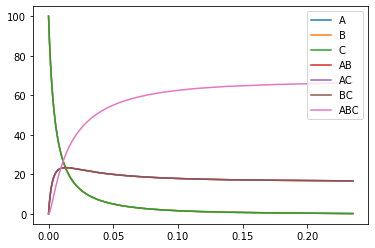

In [20]:
nodes_list = ['A','B','C','ABC','AB','BC','AC']
#nodes_list = ['AB','BMS','ABS','AMS','ABMS','AM','BM','MS']
optim.plot_observable(0,nodes_list)


**After 750 optimization iterations**


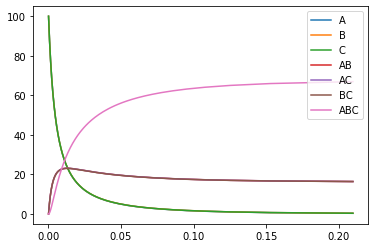

In [21]:

optim.plot_observable(-1,nodes_list)


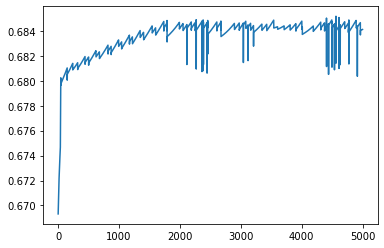

In [22]:
optim.plot_yield()

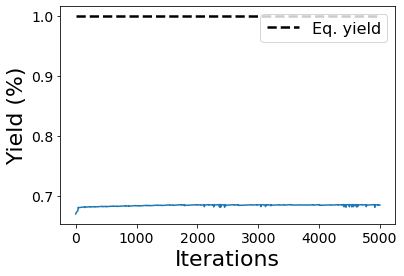

In [23]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.plot(optim.yield_per_iter)
f_dict = {'fontsize':22}
ax.set_ylabel("Yield (%)",fontdict=f_dict)
ax.set_xlabel("Iterations",fontdict=f_dict)
plt.tick_params(axis='both',labelsize=14.0)
ax.hlines(y=0.999,xmin=0,xmax=5000,linewidth=2.5,linestyle='dashed',label='Eq. yield')
ax.legend(fontsize=16)

It seems like we've found a stable solution that produces greater yield than equilibrium. This should be thermodynamically
impossible. Let's try to find an explanation. We'll run simulations using the learned optimal parameters at a few different
timescales.

No handles with labels found to put in legend.


Using CPU
Next time:  tensor(13.9494, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
Using CPU
Next time:  tensor(107.3490, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Using CPU
Next time:  tensor(571.6966, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.
Using CPU
Next time:  tensor(1306.8425, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.


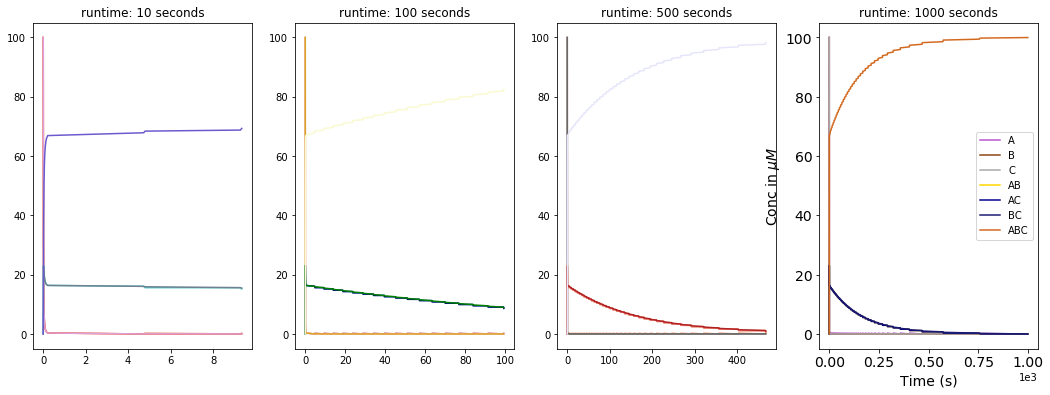

In [24]:
from matplotlib import pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1, 4)
optim_rn = optim.rn
for i, runtime in enumerate([10, 100, 500,1000]):
    optim_rn.reset()
    sim = VecSim(optim_rn, runtime, device='cpu')
    y = sim.simulate()
    sim.plot_observable(nodes_list,ax=ax[i])
    ax[i].set_title("runtime: " + str(runtime) + " seconds")
fig.set_size_inches(18, 6)
plt.show()

In [25]:
def get_max_edge(n):
    """
    Calculates the max rate (k_on) for a given node
    To find out the maximum flow path to the final complex starting from the current node.
    
    Can also calculate the total rate of consumption of a node by summing up all rates. 
    Can tell which component is used quickly.
    """
    try:
        edges = rn.network.out_edges(n)
        #Loop over all edges
        #Get attributes
        kon_max = -1
        next_node = -1

        kon_sum = 0
        total_flux_outedges = 0
        total_flux_inedges = 0
        if len(edges)==0:
            return(False)
            
        for edge in edges:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']

            #Get updated kon
            temp_kon = vec_rn.kon[uid]
            kon_sum+=temp_kon
            
            if temp_kon > kon_max:
                kon_max = temp_kon
                next_node=edge[1]
             
        return(kon_max,next_node,kon_sum)
    except Exception as err:
        raise(err)

        
def get_node_flux(n):
    total_flux_outedges = 0
    total_flux_inedges = 0
    #Go over all the out edges
    edges_out = rn.network.out_edges(n)
    if len(edges_out)>0:

        for edge in edges_out:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']

            #Get updated kon
            temp_kon = vec_rn.kon[uid]

            #Calculate k_off also
            std_c = Tensor([1.])
            l_kon = torch.log(temp_kon)
            l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
            koff = torch.exp(l_koff)

            #Getting conc. of reactants and products
            #Get product
            prod = gtostr(rn.network.nodes[edge[1]]['struct']) 
            #Get other reactant
            react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))

            #Net flux from this edge = Generation - consumption
            edge_flux = koff*vec_rn.copies_vec[edge[1]] - temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])
            #edge_flux = koff*vec_rn.copies_vec[edge[1]] 

            print("Reaction: ", gtostr(rn.network.nodes[edge[0]]['struct']), "+",react," -> ",prod)
            print("Net flux: ",edge_flux)
            print("kon : ",temp_kon)
            print("koff: ",koff)
            print("Reaction data OUTWARD: ")
            print(data)

            total_flux_outedges+=edge_flux
    
    #Now go over all the in edges
    edges_in = rn.network.in_edges(n)
    react_list = []
    if len(edges_in) > 0:
        for edge in edges_in:
            if edge[0] in react_list:
                continue
            data = rn.network.get_edge_data(edge[0],edge[1])
            uid = data['uid']


            #Get generation rates; which would be kon
            temp_kon = vec_rn.kon[uid]

            #Get consumption rates; which is k_off
            std_c = Tensor([1.])
            l_kon = torch.log(temp_kon)
            l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
            koff = torch.exp(l_koff)

            #Get conc. of reactants and products
            prod = gtostr(rn.network.nodes[edge[1]]['struct'])
            #Get other reactant
            react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))
            react_list.append(node_map[react])
            #Net flux from this edge = Generation - consumption
            edge_flux_in = temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])- koff*vec_rn.copies_vec[edge[1]]
            #edge_flux_in = koff*vec_rn.copies_vec[edge[1]]
            


            print("Reaction: ", prod ," -> ",gtostr(rn.network.nodes[edge[0]]['struct']), "+",react)
            print("Net flux: ",edge_flux_in)
            print("kon : ",temp_kon)
            print("koff: ",koff)
            print("Raction data INWARD: ")
            print(data)

            total_flux_inedges+=edge_flux_in
    net_node_flux = total_flux_outedges + total_flux_inedges
    
    return(net_node_flux)
    
pathway = []
kon_sumarray = []
total_con_rate = {}
net_flux = {}
for n in rn.network.nodes():
    
    n_str = gtostr(rn.network.nodes[n]['struct']) 
    
    paths = [n_str]
    kon_sum = 0
    temp_node = n
    max_edge = True
    consumption_rate = 0
    if n < len(rn.network.nodes()):#num_monomers:
#         print("Current node: ")
#         print(n_str)
        while max_edge:
            max_edge = get_max_edge(temp_node)
            if max_edge:
                total_con_rate[gtostr(rn.network.nodes[temp_node]['struct'])] = max_edge[2]
                
                temp_node = max_edge[1]
                kon_sum += max_edge[0].item()
                
                
#                 print("Next node: ")
#                 print(temp_node)

                paths.append(gtostr(rn.network.nodes[temp_node]['struct']))
            else:
                break
        pathway.append(paths)
        kon_sumarray.append(kon_sum)
        paths=[]
    print("-------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------")
    print("|                                                                             |")
    node_flux = get_node_flux(n)
    net_flux[gtostr(rn.network.nodes[n]['struct'])] = node_flux
    print("|                                                                             |")
    print("-------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------")

print(pathway)
print(kon_sumarray)

#print(total_con_rate)

-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|                                                                             |
Reaction:  A + B  ->  AB
Net flux:  tensor([-5.3615e-05], dtype=torch.float64, grad_fn=<SubBackward0>)
kon :  tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
koff:  tensor([0.9912], dtype=torch.float64, grad_fn=<ExpBackward>)
Reaction data OUTWARD: 
{'k_on': 1.0, 'k_off': 0.002061153622438557, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
Reaction:  A + C  ->  AC
Net flux:  tensor([-3.9386e-05], dtype=torch.float64, grad_fn=<SubBackward0>)
kon :  tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
koff:  tensor([0.9912], dtype=torch.float64, grad_fn=<ExpBackward>)
Reaction data OUTWARD: 
{'k_on': 1.0, 'k_off': 0.002061153622438557, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 1}
Reaction: 

In [26]:
for k,v in sorted(net_flux.items(),key=lambda x : x[1]):
    print(k," : ", v)

print(vec_rn.copies_vec)
print(vec_rn.kon)

ABC  :  tensor([-294.7366], dtype=torch.float64, grad_fn=<AddBackward0>)
BC  :  tensor([98.2431], dtype=torch.float64, grad_fn=<AddBackward0>)
A  :  tensor([98.2454], dtype=torch.float64, grad_fn=<AddBackward0>)
AC  :  tensor([98.2456], dtype=torch.float64, grad_fn=<AddBackward0>)
AB  :  tensor([98.2456], dtype=torch.float64, grad_fn=<AddBackward0>)
B  :  tensor([98.2479], dtype=torch.float64, grad_fn=<AddBackward0>)
C  :  tensor([98.2479], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([8.6548e-03, 6.1948e-03, 6.1806e-03, 0.0000e+00, 1.4230e-05, 2.4743e-03,
        9.9991e+01], dtype=torch.float64, grad_fn=<MaxBackward2>)
tensor([1., 1., 1., 1., 1., 1.], dtype=torch.float64, grad_fn=<CopySlices>)


In [27]:
print(solution)
poly_system = EquilibriumSolver(rn)
solution = poly_system.solve(init_val=vec_rn.copies_vec.detach().numpy().tolist())
#solution = poly_system.solve(verifyBool = False)
if solution == None:
    print("No Equilibrium solution")
else:
    print(solution)
    print("Equilibrium expected yield: ", 100 * solution[-1] / min(vec_rn.initial_copies[:vec_rn.num_monomers]), '%')
print(vec_rn.kon)

None
Matrix([[0.0001015107], [0.0001015107], [0.0001015107], [4.591091e-6], [4.591091e-6], [4.591150e-6], [99.99989]])
Equilibrium expected yield:  99.9998889160156 %
tensor([1., 1., 1., 1., 1., 1.], dtype=torch.float64, grad_fn=<CopySlices>)


In [28]:
print(solution)
poly_system = EquilibriumSolver(rn)
solution = poly_system.solve(verifyBool = False)
if solution == None:
    print("No Equilibrium solution")
else:
    print(solution)
    print("Equilibrium expected yield: ", 100 * solution[-1] / min(vec_rn.initial_copies[:vec_rn.num_monomers]), '%')
print(vec_rn.kon)

Matrix([[0.0001015107], [0.0001015107], [0.0001015107], [4.591091e-6], [4.591091e-6], [4.591150e-6], [99.99989]])
Matrix([[0.09191163], [0.06966965], [0.05792693], [0.01618169], [0.02792583], [0.05017105], [99.86398]])
Equilibrium expected yield:  99.8639782714844 %
tensor([1., 1., 1., 1., 1., 1.], dtype=torch.float64, grad_fn=<CopySlices>)


[False False False ... False False False]


/media/Data1/adip/software/anaconda3/envs/steric_free_sim/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/media/Data1/adip/software/anaconda3/envs/steric_free_sim/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/media/Data1/adip/software/anaconda3/envs/steric_free_sim/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


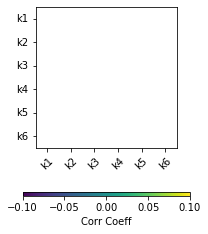

Text(0.5, 1, '0.8 - 0.9 Yield range\nNumber of samples: 0.02 %')

In [29]:
def corr_matrix(M):
    return(np.corrcoef(M))

#Select data range to calculate coorelations
yield_thresh_min = 0.8
yield_thresh_max = 0.9
mask1 = (np.array(optim.final_yields) >= yield_thresh_min) & (np.array(optim.final_yields) < yield_thresh_max)
print(mask1)

coor_params = np.zeros((6,1))
for i in range(len(mask1)):
    if mask1[i]:
        coor_params = np.concatenate((coor_params,np.reshape(optim.final_solns[i].numpy(),(6,1))),axis=1)

corr_matrix = corr_matrix(coor_params)

# %matplotlib notebook
fig_c,ax_c = plt.subplots()
hm = ax_c.imshow(corr_matrix)
ax_labels=['k1','k2','k3','k4','k5','k6']
ax_c.set_xticks(np.arange(len(ax_labels)))
ax_c.set_yticks(np.arange(len(ax_labels)))
ax_c.set_xticklabels(ax_labels)
ax_c.set_yticklabels(ax_labels)
plt.setp(ax_c.get_xticklabels(),rotation=45, ha='center',fontsize=10,va='top')
plt.setp(ax_c.get_yticklabels(),va='center',fontsize=10)
fig_c.colorbar(hm,ax=ax_c,aspect=40,label="Corr Coeff",orientation='horizontal',panchor=(0.5,0.0),pad=0.2,shrink=0.5)
# ax_c.grid()

plt.show()
label = "Number of samples: %.2f %s" %(coor_params.shape[1]*100/len(optim.final_solns),"%")
yield_label = "%.1f - %.1f Yield range\n" %(yield_thresh_min,yield_thresh_max)
ax_c.set_title(yield_label+label)

Clearly, the equilibrium reached by the system still matches the equilibrium solution. We have however found a set of parameters that can increase available complete AP2 at some point before equilibrium to levels significantly higher than at equilibrium. We don't observe any trapping, but have uncovered an interesting effect. 

Now we'll move on to looking at ARP23. This is 7 subunits, which drastically increases the number of possible reactions. Expect longer runtimes. 